In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import datetime as dt
import cartopy.crs as ccrs
from merge_data_barpa import load_stn_info
import xarray as xr
import timezonefinder
import pytz


In [2]:
#Read daily maximum wind gusts at each station, created by resample_daily_max.py

dmax_2p2km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_2p2km.csv")
dmax_2p2km_interp = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_2p2km_barpa_r_interp.csv")
dmax_12km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_12km.csv")
dmax_obs = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_obs.csv")
dmax_bdsd = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_bdsd.csv")
dmax_erai = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_erai.csv")

#Calculate another ratio, the gust to deep-layer mean
dmax_2p2km_point["dlm_ratio"] = dmax_2p2km_point["wg10_2p2km_point"] / dmax_2p2km_point["Umean06"]
dmax_12km_point["dlm_ratio"] = dmax_12km_point["wg10_12km_point"] / dmax_12km_point["Umean06"]
dmax_obs["dlm_ratio"] = dmax_obs["gust"] / dmax_obs["Umean06_era5"]

dmax_2p2km_point = dmax_2p2km_point.set_index(pd.to_datetime(dmax_2p2km_point.time))
dmax_2p2km_interp = dmax_2p2km_interp.set_index(pd.to_datetime(dmax_2p2km_interp.time))
dmax_12km_point = dmax_12km_point.set_index(pd.to_datetime(dmax_12km_point.time))
dmax_obs = dmax_obs.set_index(pd.to_datetime(dmax_obs.time))
dmax_bdsd = dmax_bdsd.set_index(pd.to_datetime(dmax_bdsd.time))

In [3]:
#Suspect gusts to drop - observations
obs_times = pd.to_datetime(dmax_obs.time)
dmax_obs.loc[(obs_times.dt.month == 12) & (obs_times.dt.year == 2010) & (dmax_obs.stn_id==55325) & (dmax_obs.gust >= 25),"gust"] = np.nan
dmax_obs.loc[dmax_obs.gust>=129, "gust"] = np.nan 


In [4]:
print("Number of stations: ",dmax_obs.stn_id.unique().shape[0])

Number of stations:  272


In [5]:
#Take the domain maximum for each day
dmax_2p2km_all = dmax_2p2km_point.sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_2p2km_interp_all = dmax_2p2km_interp.sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_all = dmax_12km_point.sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_all = dmax_obs.dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_bdsd_all = dmax_bdsd.sort_values("bdsd_era5").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_erai_all = dmax_erai.sort_values("erai_wg10").drop_duplicates("dt_floor_1D",keep="last").sort_index()

In [6]:
#Take the domain maximum for each day using daily maximum observations at each station with lightning
dmax_2p2km_conv = dmax_2p2km_point.query("n_lightning_fl>=1").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_2p2km_interp_conv = dmax_2p2km_interp.query("n_lightning_fl>=1").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_conv = dmax_12km_point.query("n_lightning_fl>=1").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_conv = dmax_obs.query("Lightning_observed_daily>=1").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()

#Take the domain maximum for each day using daily maximum observations at each station without lightning
dmax_2p2km_nonconv = dmax_2p2km_point.query("n_lightning_fl==0").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_2p2km_interp_nonconv = dmax_2p2km_interp.query("n_lightning_fl==0").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_nonconv = dmax_12km_point.query("n_lightning_fl==0").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_nonconv = dmax_obs.query("Lightning_observed_daily==0").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()


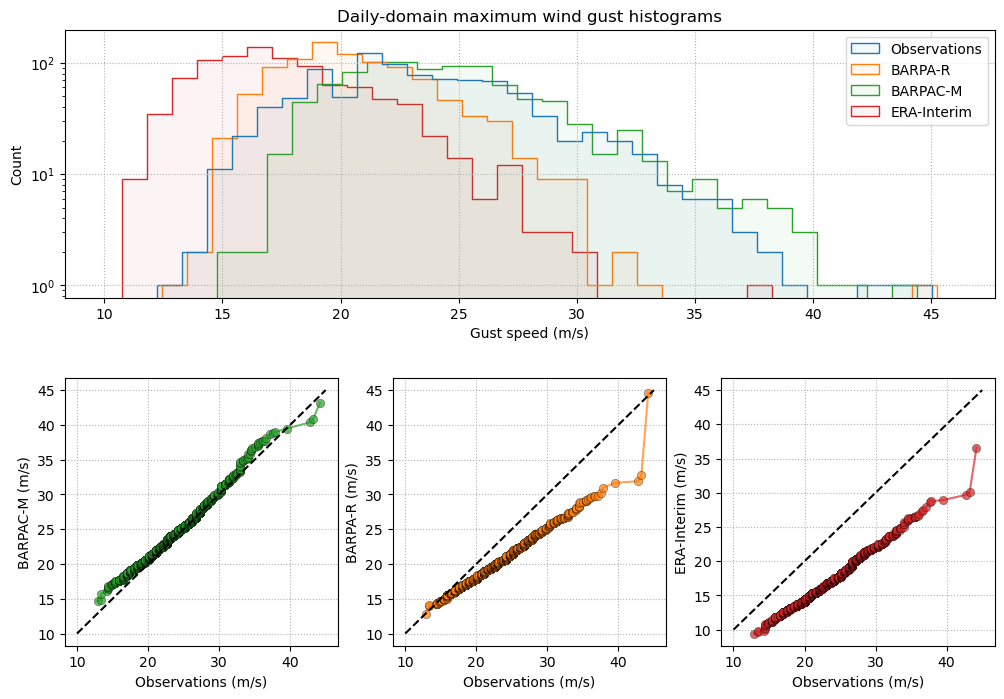

In [7]:
#Use seaborn to plot a stepped histoigram for daily-domain maximum data as a comparison
# between model and observations

plt.figure(figsize=[12,8])

plt.subplot2grid((2,3),(0,0),1,3)

values_2p2km = dmax_2p2km_all["wg10_2p2km_point"].values
values_12km = dmax_12km_all["wg10_12km_point"].values
values_obs = dmax_obs_all["gust"].values
values_erai = dmax_erai_all["erai_wg10"].values
temp_df = pd.DataFrame({"Observations":values_obs, "BARPA-R":values_12km, "BARPAC-M":values_2p2km,"ERA-Interim":values_erai})

hist = sns.histplot(data=temp_df, bins=np.linspace(10,46,35),
             log_scale=[False,True], multiple="dodge", shrink=0.8, stat="count",common_norm=False,
             element="step",alpha=0.05,legend=True,palette="tab10")

plt.gca().grid(ls=":")
plt.xlabel("Gust speed (m/s)")
plt.title("Daily-domain maximum wind gust histograms")

#Use pyplot to plot a rank-size wind gust distribution

plt.subplot2grid((2,3),(1,0),1,1)
p=1000
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_2p2km,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:green")
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M (m/s)")
plt.xlabel("Observations (m/s)")

plt.subplot2grid((2,3),(1,1),1,1)
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_12km,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("BARPA-R (m/s)")
plt.xlabel("Observations (m/s)")

plt.subplot2grid((2,3),(1,2),1,1)
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_erai,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:red")
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("ERA-Interim (m/s)")
plt.xlabel("Observations (m/s)")

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/hist.jpeg",dpi=400)

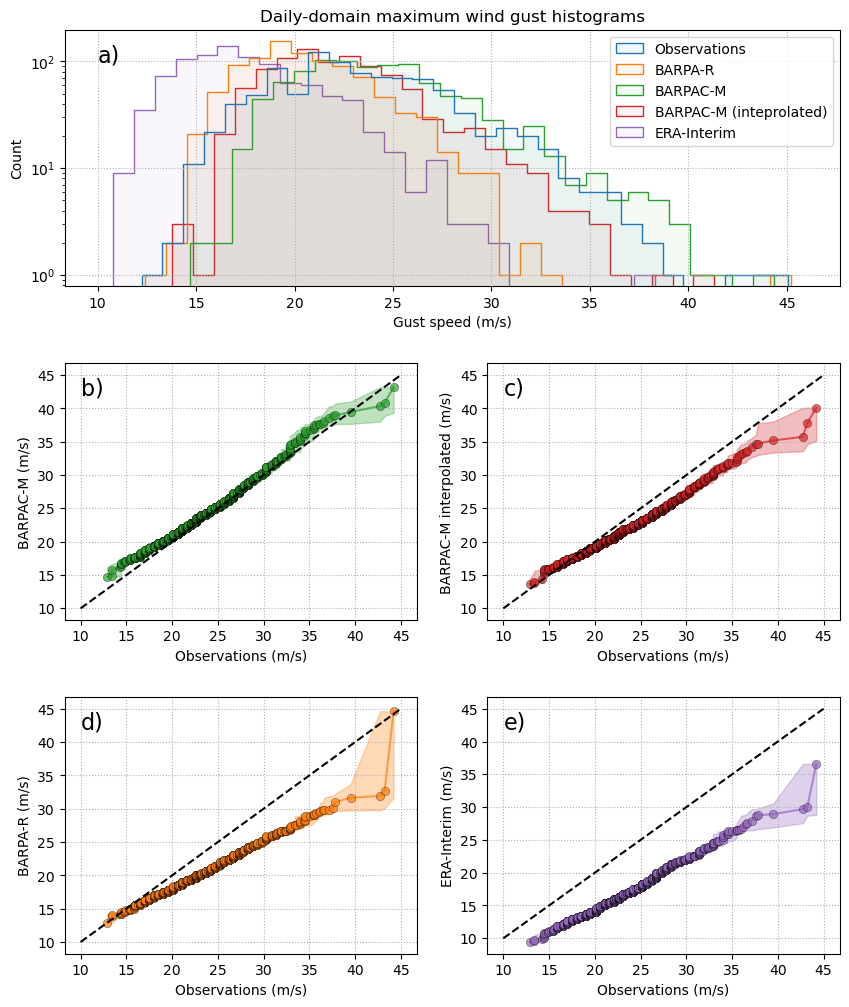

In [8]:
#Same as above but with BARPAC interpolated to BARPA-R grid
#Include 95% confidence intervals by resampling each model time series and comparing the percentiles with observations

plt.figure(figsize=[10,12])

plt.subplot2grid((3,2),(0,0),1,2)

values_2p2km = dmax_2p2km_all["wg10_2p2km_point"].values
values_2p2km_interp = dmax_2p2km_interp_all["wg10_2p2km_point"].values
values_12km = dmax_12km_all["wg10_12km_point"].values
values_obs = dmax_obs_all["gust"].values
values_erai = dmax_erai_all["erai_wg10"].values
temp_df = pd.DataFrame({"Observations":values_obs, "BARPA-R":values_12km, "BARPAC-M":values_2p2km, "BARPAC-M (inteprolated)":values_2p2km_interp, "ERA-Interim":values_erai})

hist = sns.histplot(data=temp_df, bins=np.linspace(10,46,35),
             log_scale=[False,True], multiple="dodge", shrink=0.8, stat="count",common_norm=False,
             element="step",alpha=0.05,legend=True,palette="tab10")

plt.gca().grid(ls=":")
plt.xlabel("Gust speed (m/s)")
plt.title("Daily-domain maximum wind gust histograms")
plt.text(10,100,"a)",size=16)

#Use pyplot to plot a rank-size wind gust distribution

plt.subplot2grid((3,2),(1,0),1,1)
p=1000
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_2p2km,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:green")
#obs_resamp = [np.percentile(values_obs[np.random.randint(0,len(values_obs),len(values_obs))],np.linspace(0,100,p)) for N in np.arange(1000)]
mod_resamp = [np.percentile(values_2p2km[np.random.randint(0,len(values_2p2km),len(values_2p2km))],np.linspace(0,100,p)) for N in np.arange(1000)]
plt.fill_between(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:green",alpha=0.3)

plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(10,42,"b)",size=16)

plt.subplot2grid((3,2),(1,1),1,1)
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_2p2km_interp,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:red")
mod_resamp = [np.percentile(values_2p2km_interp[np.random.randint(0,len(values_2p2km_interp),len(values_2p2km_interp))],np.linspace(0,100,p)) for N in np.arange(1000)]
plt.fill_between(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:red",alpha=0.3)
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M interpolated (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(10,42,"c)",size=16)

plt.subplot2grid((3,2),(2,0),1,1)
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_12km,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
mod_resamp = [np.percentile(values_12km[np.random.randint(0,len(values_12km),len(values_12km))],np.linspace(0,100,p)) for N in np.arange(1000)]
plt.fill_between(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:orange",alpha=0.3)
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("BARPA-R (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(10,42,"d)",size=16)

plt.subplot2grid((3,2),(2,1),1,1)
plt.plot(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(values_erai,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:purple")
mod_resamp = [np.percentile(values_erai[np.random.randint(0,len(values_erai),len(values_erai))],np.linspace(0,100,p)) for N in np.arange(1000)]
plt.fill_between(np.percentile(values_obs,np.linspace(0,100,p)),np.percentile(np.stack(mod_resamp),2.5,axis=0),np.percentile(np.stack(mod_resamp),97.5,axis=0), color="tab:purple",alpha=0.3)
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("ERA-Interim (m/s)")
plt.xlabel("Observations (m/s)")
plt.text(10,42,"e)",size=16)

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/hist2.jpeg",dpi=400,bbox_inches="tight")

In [9]:
values_2p2km = dmax_2p2km_all["wg10_2p2km_point"].values
values_2p2km_interp = dmax_2p2km_interp_all["wg10_2p2km_point"].values
values_12km = dmax_12km_all["wg10_12km_point"].values
values_obs = dmax_obs_all["gust"].values
values_erai = dmax_erai_all["erai_wg10"].values

temp_df = pd.DataFrame({"Observations (m/s)":values_obs, "BARPA-R (bias and error, m/s)":values_12km, "BARPAC-M (bias and error, m/s)":values_2p2km, "BARPAC-M inteprolated (bias and error, m/s)":values_2p2km_interp, "ERA-Interim (bias and error, m/s)":values_erai})

#Calculate biases (wind gust speeds) for percentiles specified by p. Also calculate lower and upper CI by resampling the model time series and compare percentiles against the observed percentiles 
stats = pd.DataFrame()
upper = pd.DataFrame()
lower = pd.DataFrame()
p = [0,25,50,75,100]
t=100
for c in temp_df.columns:
    if c == "Observations (m/s)":
        stats = pd.concat([stats,pd.DataFrame({c:np.percentile(temp_df[c],p)},index=[str(s)+"th percentile" for s in p])],axis=1)
        lower = pd.concat([lower,pd.DataFrame({c:[""]*len(p)},index=[str(s)+"th percentile" for s in p])],axis=1)
        upper = pd.concat([upper,pd.DataFrame({c:[""]*len(p)},index=[str(s)+"th percentile" for s in p])],axis=1)
    else:
        stats = pd.concat([stats,pd.DataFrame(
            {c:np.percentile(temp_df[c],p) - np.percentile(temp_df["Observations (m/s)"],p)},index=[str(s)+"th percentile" for s in p]
        )],axis=1)
        
        lower = pd.concat([lower,
                   pd.DataFrame({c:
                                 np.percentile(np.stack([np.percentile(temp_df[c].values[np.random.randint(0,len(temp_df[c].values),len(temp_df[c].values))],p) for N in np.arange(1000)]
                                 - np.percentile(temp_df["Observations (m/s)"],p)),2.5,axis=0)
                                },index=[str(s)+"th percentile" for s in p])],
                  axis=1)
        upper = pd.concat([upper,
                   pd.DataFrame({c:
                                 np.percentile(np.stack([np.percentile(temp_df[c].values[np.random.randint(0,len(temp_df[c].values),len(temp_df[c].values))],p) for N in np.arange(1000)]
                                 - np.percentile(temp_df["Observations (m/s)"],p)),97.5,axis=0)
                                },index=[str(s)+"th percentile" for s in p])],
                  axis=1)
        
stats = stats.round(2)

#The below code includes confidence estimates on wind gust bias for each percentile
#stats.iloc[:,1:] = stats.iloc[:,1:].astype(str) + " (" + lower.round(2).iloc[:,1:].astype(str) + ", "+upper.round(2).iloc[:,1:].astype(str)+")"

#Calculate mean error for 100 percentiles from 0 to 100
for mod,name in zip([values_obs,values_12km,values_2p2km,values_2p2km_interp,values_erai],stats.columns):

    me = str(np.round(
            np.mean(
            np.percentile(mod,np.linspace(0,100,t)) - np.percentile(values_obs,np.linspace(0,100,t))),2))
    lower = str(np.round(np.percentile([
            np.mean(
            np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)) - np.percentile(values_obs,np.linspace(0,100,t))) for N in np.arange(1000)],2.5),2))
    upper = str(np.round(np.percentile([
            np.mean(
            np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)) - np.percentile(values_obs,np.linspace(0,100,t))) for N in np.arange(1000)],97.5),2))
    
    stats.loc["Mean error",name] = me + " ("+lower+", "+upper+")"
    
stats.loc["Mean error","Observations (m/s)"] = "-"

#Calculate RMSE for 100 percentiles from 0 to 100
# for mod,name in zip([values_obs,values_12km,values_2p2km,values_2p2km_interp,values_erai],stats.columns):

#     rmse = str(np.round(np.sqrt(
#             np.mean((
#             np.percentile(values_obs,np.linspace(0,100,t)) - np.percentile(mod,np.linspace(0,100,t)))**2)),2))
#     lower = str(np.round(np.percentile([np.sqrt(
#             np.mean((
#             np.percentile(values_obs,np.linspace(0,100,t)) - np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)))**2)) for N in np.arange(1000)],2.5),2))
#     upper = str(np.round(np.percentile([np.sqrt(
#             np.mean((
#             np.percentile(values_obs,np.linspace(0,100,t)) - np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)))**2)) for N in np.arange(1000)],97.5),2))
    
#     stats.loc["RMSE",name] = rmse + " ("+lower+", "+upper+")"
    
# stats.loc["RMSE","Observations (m/s)"] = "-"

In [10]:
stats[["Observations (m/s)","BARPAC-M (bias and error, m/s)","BARPAC-M inteprolated (bias and error, m/s)","BARPA-R (bias and error, m/s)","ERA-Interim (bias and error, m/s)"]]


,Observations (m/s),"BARPAC-M (bias and error, m/s)","BARPAC-M inteprolated (bias and error, m/s)","BARPA-R (bias and error, m/s)","ERA-Interim (bias and error, m/s)"
0th percentile,12.9,1.82,0.72,-0.03,-3.47
25th percentile,20.1,0.76,-0.8,-1.98,-5.72
50th percentile,22.81,0.75,-1.36,-2.81,-6.46
75th percentile,26.2,0.25,-2.17,-3.7,-7.1
100th percentile,44.2,-1.02,-4.1,0.42,-7.61
Mean error,-,"0.69 (0.41, 0.94)","-1.49 (-1.72, -1.26)","-2.86 (-3.17, -2.66)","-6.42 (-6.69, -6.21)"


In [11]:
stats[["Observations (m/s)","BARPAC-M (bias and error, m/s)","BARPAC-M inteprolated (bias and error, m/s)","BARPA-R (bias and error, m/s)","ERA-Interim (bias and error, m/s)"]].to_latex(
            )



/jobfs/86493737.gadi-pbs/ipykernel_913099/828559268.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  stats[["Observations (m/s)","BARPAC-M (bias and error, m/s)","BARPAC-M inteprolated (bias and error, m/s)","BARPA-R (bias and error, m/s)","ERA-Interim (bias and error, m/s)"]].to_latex(


'\\begin{tabular}{llllll}\n\\toprule\n{} & Observations (m/s) & BARPAC-M (bias and error, m/s) & BARPAC-M inteprolated (bias and error, m/s) & BARPA-R (bias and error, m/s) & ERA-Interim (bias and error, m/s) \\\\\n\\midrule\n0th percentile   &               12.9 &                           1.82 &                                        0.72 &                         -0.03 &                             -3.47 \\\\\n25th percentile  &               20.1 &                           0.76 &                                        -0.8 &                         -1.98 &                             -5.72 \\\\\n50th percentile  &              22.81 &                           0.75 &                                       -1.36 &                         -2.81 &                             -6.46 \\\\\n75th percentile  &               26.2 &                           0.25 &                                       -2.17 &                          -3.7 &                              -7.1 \\\\\n100th perc

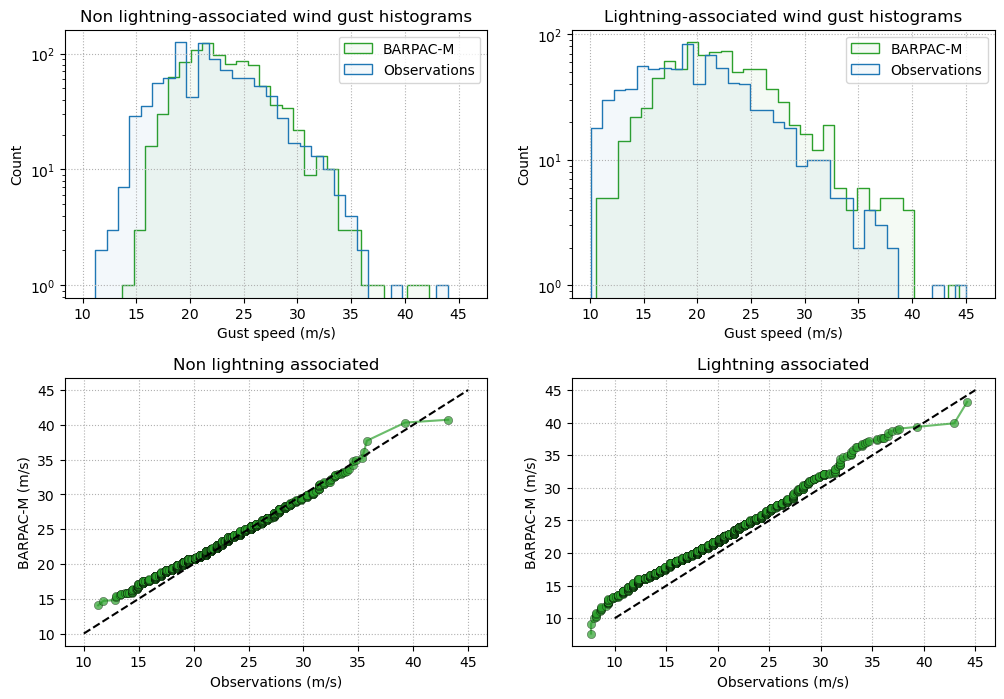

In [12]:
#Use seaborn to plot a stepped histoigram for daily-domain maximum data as a comparison
# between model and observations

plt.figure(figsize=[12,8])

values_2p2km_conv = dmax_2p2km_conv["wg10_2p2km_point"].values
values_2p2km_nonconv = dmax_2p2km_nonconv["wg10_2p2km_point"].values
values_obs_conv = dmax_obs_conv["gust"].values
values_obs_nonconv = dmax_obs_nonconv["gust"].values

plt.subplot2grid((2,2),(0,0),1,1)
hist = sns.histplot(data=[values_obs_nonconv,values_2p2km_nonconv], bins=np.linspace(10,46,35),
             log_scale=[False,True], multiple="dodge", shrink=0.8, stat="count",common_norm=False,
             element="step",alpha=0.05,legend=False,palette=[plt.get_cmap("tab10")(0),plt.get_cmap("tab10")(2)])
plt.title("Non lightning-associated wind gust histograms")
plt.xlabel("Gust speed (m/s)")
plt.gca().grid(ls=":")
plt.legend(["BARPAC-M","Observations"])

plt.subplot2grid((2,2),(0,1),1,1)
hist = sns.histplot(data=[values_obs_conv,values_2p2km_conv], bins=np.linspace(10,46,35),
             log_scale=[False,True], multiple="dodge", shrink=0.8, stat="count",common_norm=False,
             element="step",alpha=0.05,legend=False,palette=[plt.get_cmap("tab10")(0),plt.get_cmap("tab10")(2)])
plt.legend(["BARPAC-M","Observations"])

plt.gca().grid(ls=":")
plt.xlabel("Gust speed (m/s)")
plt.title("Lightning-associated wind gust histograms")

#Use pyplot to plot a rank-size wind gust distribution

plt.subplot2grid((2,2),(1,0),1,1)
p=1000
plt.plot(np.percentile(values_obs_nonconv,np.linspace(0,100,p)),np.percentile(values_2p2km_nonconv,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:green")
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M (m/s)")
plt.xlabel("Observations (m/s)")
plt.title("Non lightning associated")

plt.subplot2grid((2,2),(1,1),1,1)
plt.plot(np.percentile(values_obs_conv,np.linspace(0,100,p)),np.percentile(values_2p2km_conv,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:green")
plt.plot([10,45],[10,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("BARPAC-M (m/s)")
plt.xlabel("Observations (m/s)")
plt.title("Lightning associated")

plt.subplots_adjust(hspace=0.3)

#plt.savefig("/g/data/eg3/ab4502/figs/barpa/hist.jpeg",dpi=400)

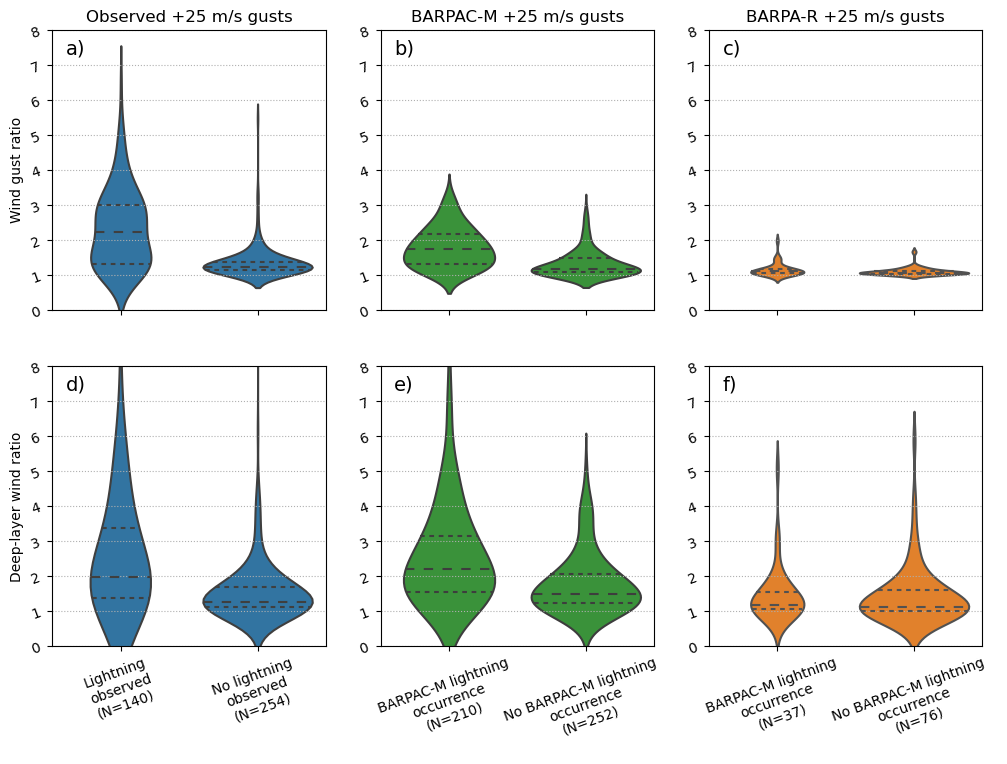

In [13]:
plt.figure(figsize=[12,8])

plt.subplot(2,3,1)

sns.violinplot(
    [dmax_obs_conv.query("(gust>=25)").wgr_4,
    dmax_obs_nonconv.query("(gust>=25)").wgr_4],inner="quartile",scale="count",bw=0.5,palette=["tab:blue","tab:blue"])
# n_str1 = "(N="+str(dmax_obs_conv.query("(gust>=25)").shape[0])+")"
# n_str2 = "(N="+str(dmax_obs_nonconv.query("(gust>=25)").shape[0])+")"
# plt.xticks([0,1],["Lightning\nobserved\n"+n_str1,"No lightning\nobserved\n"+n_str2])
plt.xticks([0,1],["",""])
plt.ylim([0,8])
plt.title("Observed +25 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.ylabel("Wind gust ratio")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"a)",size=14)

plt.subplot(2,3,3)

sns.violinplot(
    [dmax_12km_conv.query("(wg10_12km_point>=25)").wgr_12km_point,
    dmax_12km_nonconv.query("(wg10_12km_point>=25)").wgr_12km_point],inner="quartile",scale="count",bw=0.5,palette=["tab:orange","tab:orange"])
plt.ylim([0,8])
# n_str1 = "(N="+str(dmax_12km_conv.query("(wg10_12km_point>=25)").shape[0])+")"
# n_str2 = "(N="+str(dmax_12km_nonconv.query("(wg10_12km_point>=25)").shape[0])+")"
# plt.xticks([0,1],["BARPAC-M lightning\nobserved\n"+n_str1,"No BARPAC-M lightning\nobserved\n"+n_str2])
plt.xticks([0,1],["",""])
plt.title("BARPA-R +25 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"c)",size=14)

plt.subplot(2,3,2)

sns.violinplot(
    [dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").wgr_2p2km_point,
    dmax_2p2km_nonconv.query("(wg10_2p2km_point>=25)").wgr_2p2km_point],inner="quartile",scale="count",bw=0.5,palette=["tab:green","tab:green"])
plt.ylim([0,8])
# n_str1 = "(N="+str(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").shape[0])+")"
# n_str2 = "(N="+str(dmax_2p2km_nonconv.query("(wg10_2p2km_point>=25)").shape[0])+")"
# plt.xticks([0,1],["BARPAC-M lightning\nobserved\n"+n_str1,"No BARPAC-M lightning\nobserved\n"+n_str2])
plt.xticks([0,1],["",""])
plt.title("BARPAC-M +25 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"b)",size=14)


plt.subplot(2,3,4)

sns.violinplot(
    [dmax_obs_conv.query("(gust>=25)").dlm_ratio,
    dmax_obs_nonconv.query("(gust>=25)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:blue","tab:blue"])
n_str1 = "(N="+str(dmax_obs_conv.query("(gust>=25)").shape[0])+")"
n_str2 = "(N="+str(dmax_obs_nonconv.query("(gust>=25)").shape[0])+")"
plt.xticks([0,1],["Lightning\nobserved\n"+n_str1,"No lightning\nobserved\n"+n_str2])
plt.ylim([0,8])
plt.gca().grid(axis="y",ls=":")
plt.ylabel("Deep-layer wind ratio")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"d)",size=14)

plt.subplot(2,3,6)

sns.violinplot(
    [dmax_12km_conv.query("(wg10_12km_point>=25)").dlm_ratio,
    dmax_12km_nonconv.query("(wg10_12km_point>=25)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:orange","tab:orange"])
plt.ylim([0,8])
n_str1 = "(N="+str(dmax_12km_conv.query("(wg10_12km_point>=25)").shape[0])+")"
n_str2 = "(N="+str(dmax_12km_nonconv.query("(wg10_12km_point>=25)").shape[0])+")"
plt.xticks([0,1],["BARPAC-M lightning\noccurrence\n"+n_str1,"No BARPAC-M lightning\noccurrence\n"+n_str2])
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"f)",size=14)

plt.subplot(2,3,5)

sns.violinplot(
    [dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").dlm_ratio,
    dmax_2p2km_nonconv.query("(wg10_2p2km_point>=25)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:green","tab:green"])
plt.ylim([0,8])
n_str1 = "(N="+str(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").shape[0])+")"
n_str2 = "(N="+str(dmax_2p2km_nonconv.query("(wg10_2p2km_point>=25)").shape[0])+")"
plt.xticks([0,1],["BARPAC-M lightning\noccurrence\n"+n_str1,"No BARPAC-M lightning\noccurrence\n"+n_str2])
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"e)",size=14)


plt.savefig("/g/data/eg3/ab4502/figs/barpa/wgr.jpeg",dpi=400,bbox_inches="tight")

Text(-0.4, 7.3, 'e)')

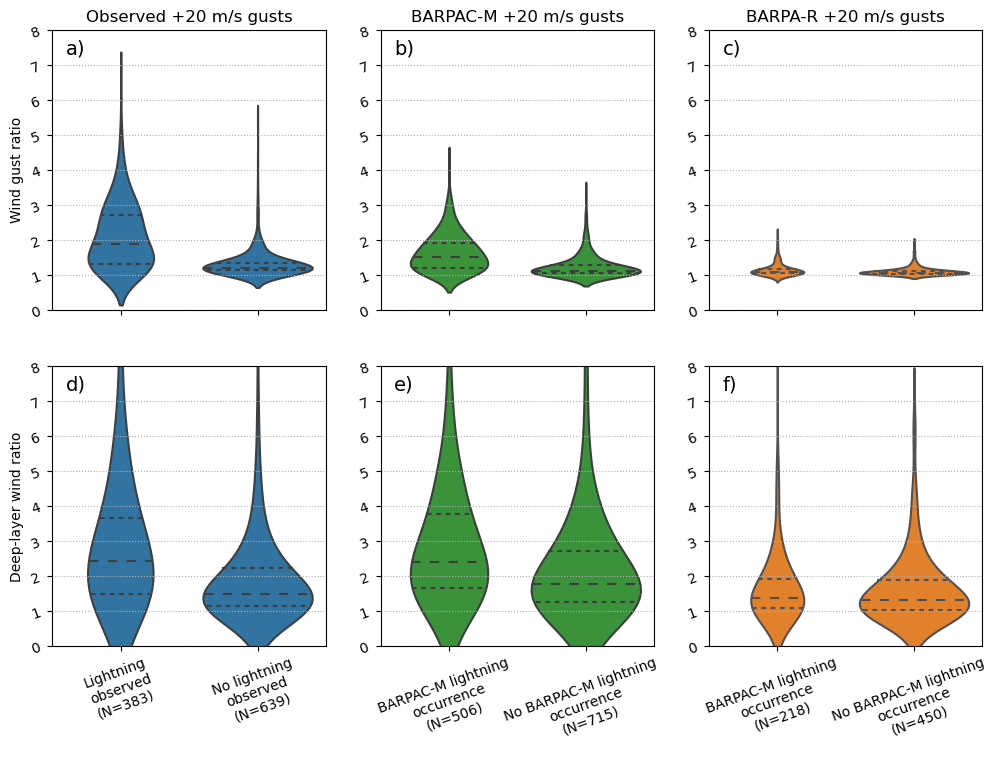

In [14]:
plt.figure(figsize=[12,8])

plt.subplot(2,3,1)

sns.violinplot(
    [dmax_obs_conv.query("(gust>=20)").wgr_4,
    dmax_obs_nonconv.query("(gust>=20)").wgr_4],inner="quartile",scale="count",bw=0.5,palette=["tab:blue","tab:blue"])

plt.xticks([0,1],["",""])
plt.ylim([0,8])
plt.title("Observed +20 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.ylabel("Wind gust ratio")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"a)",size=14)

plt.subplot(2,3,3)

sns.violinplot(
    [dmax_12km_conv.query("(wg10_12km_point>=20)").wgr_12km_point,
    dmax_12km_nonconv.query("(wg10_12km_point>=20)").wgr_12km_point],inner="quartile",scale="count",bw=0.5,palette=["tab:orange","tab:orange"])
plt.ylim([0,8])

plt.xticks([0,1],["",""])
plt.title("BARPA-R +20 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"c)",size=14)

plt.subplot(2,3,2)

sns.violinplot(
    [dmax_2p2km_conv.query("(wg10_2p2km_point>=20)").wgr_2p2km_point,
    dmax_2p2km_nonconv.query("(wg10_2p2km_point>=20)").wgr_2p2km_point],inner="quartile",scale="count",bw=0.5,palette=["tab:green","tab:green"])
plt.ylim([0,8])

plt.xticks([0,1],["",""])
plt.title("BARPAC-M +20 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"b)",size=14)


plt.subplot(2,3,4)

sns.violinplot(
    [dmax_obs_conv.query("(gust>=20)").dlm_ratio,
    dmax_obs_nonconv.query("(gust>=20)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:blue","tab:blue"])
n_str1 = "(N="+str(dmax_obs_conv.query("(gust>=20)").shape[0])+")"
n_str2 = "(N="+str(dmax_obs_nonconv.query("(gust>=20)").shape[0])+")"
plt.xticks([0,1],["Lightning\nobserved\n"+n_str1,"No lightning\nobserved\n"+n_str2])
plt.ylim([0,8])
plt.gca().grid(axis="y",ls=":")
plt.ylabel("Deep-layer wind ratio")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"d)",size=14)

plt.subplot(2,3,6)

sns.violinplot(
    [dmax_12km_conv.query("(wg10_12km_point>=20)").dlm_ratio,
    dmax_12km_nonconv.query("(wg10_12km_point>=20)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:orange","tab:orange"])
plt.ylim([0,8])
n_str1 = "(N="+str(dmax_12km_conv.query("(wg10_12km_point>=20)").shape[0])+")"
n_str2 = "(N="+str(dmax_12km_nonconv.query("(wg10_12km_point>=20)").shape[0])+")"
plt.xticks([0,1],["BARPAC-M lightning\noccurrence\n"+n_str1,"No BARPAC-M lightning\noccurrence\n"+n_str2])
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"f)",size=14)

plt.subplot(2,3,5)

sns.violinplot(
    [dmax_2p2km_conv.query("(wg10_2p2km_point>=20)").dlm_ratio,
    dmax_2p2km_nonconv.query("(wg10_2p2km_point>=20)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:green","tab:green"])
plt.ylim([0,8])
n_str1 = "(N="+str(dmax_2p2km_conv.query("(wg10_2p2km_point>=20)").shape[0])+")"
n_str2 = "(N="+str(dmax_2p2km_nonconv.query("(wg10_2p2km_point>=20)").shape[0])+")"
plt.xticks([0,1],["BARPAC-M lightning\noccurrence\n"+n_str1,"No BARPAC-M lightning\noccurrence\n"+n_str2])
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"e)",size=14)


#plt.savefig("/g/data/eg3/ab4502/figs/barpa/wgr.jpeg",dpi=400,bbox_inches="tight")

Text(-0.4, 7.3, 'e)')

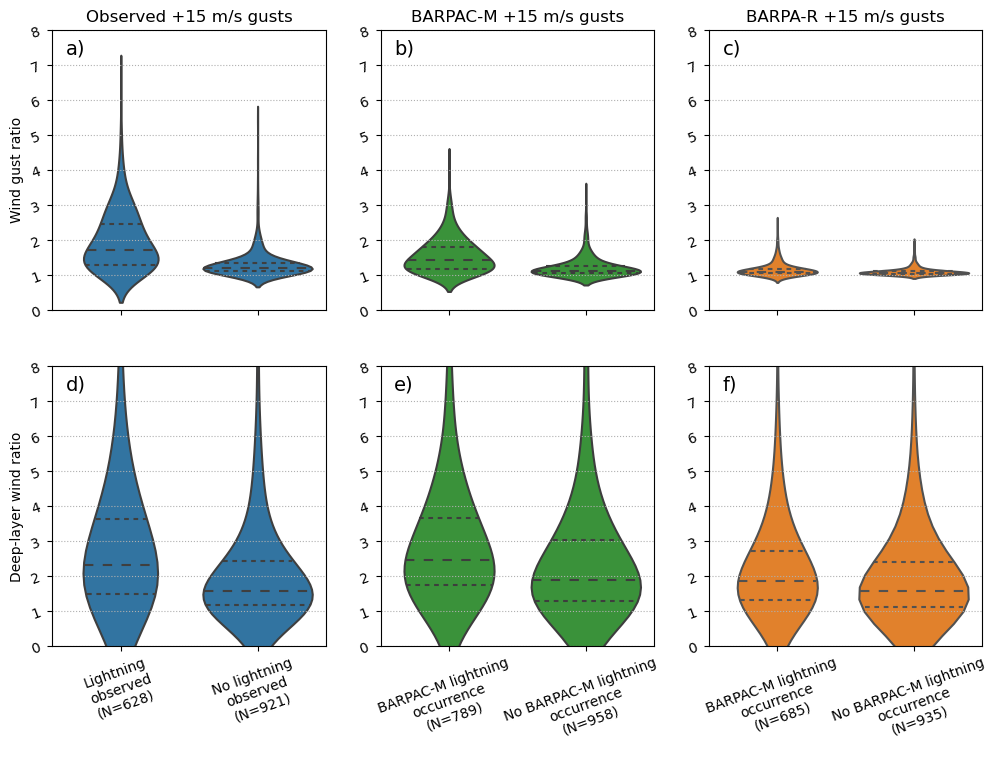

In [15]:
plt.figure(figsize=[12,8])

plt.subplot(2,3,1)

sns.violinplot(
    [dmax_obs_conv.query("(gust>=15)").wgr_4,
    dmax_obs_nonconv.query("(gust>=15)").wgr_4],inner="quartile",scale="count",bw=0.5,palette=["tab:blue","tab:blue"])

plt.xticks([0,1],["",""])
plt.ylim([0,8])
plt.title("Observed +15 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.ylabel("Wind gust ratio")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"a)",size=14)

plt.subplot(2,3,3)

sns.violinplot(
    [dmax_12km_conv.query("(wg10_12km_point>=15)").wgr_12km_point,
    dmax_12km_nonconv.query("(wg10_12km_point>=15)").wgr_12km_point],inner="quartile",scale="count",bw=0.5,palette=["tab:orange","tab:orange"])
plt.ylim([0,8])

plt.xticks([0,1],["",""])
plt.title("BARPA-R +15 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"c)",size=14)

plt.subplot(2,3,2)

sns.violinplot(
    [dmax_2p2km_conv.query("(wg10_2p2km_point>=15)").wgr_2p2km_point,
    dmax_2p2km_nonconv.query("(wg10_2p2km_point>=15)").wgr_2p2km_point],inner="quartile",scale="count",bw=0.5,palette=["tab:green","tab:green"])
plt.ylim([0,8])

plt.xticks([0,1],["",""])
plt.title("BARPAC-M +15 m/s gusts")
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"b)",size=14)


plt.subplot(2,3,4)

sns.violinplot(
    [dmax_obs_conv.query("(gust>=15)").dlm_ratio,
    dmax_obs_nonconv.query("(gust>=15)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:blue","tab:blue"])
n_str1 = "(N="+str(dmax_obs_conv.query("(gust>=15)").shape[0])+")"
n_str2 = "(N="+str(dmax_obs_nonconv.query("(gust>=15)").shape[0])+")"
plt.xticks([0,1],["Lightning\nobserved\n"+n_str1,"No lightning\nobserved\n"+n_str2])
plt.ylim([0,8])
plt.gca().grid(axis="y",ls=":")
plt.ylabel("Deep-layer wind ratio")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"d)",size=14)

plt.subplot(2,3,6)

sns.violinplot(
    [dmax_12km_conv.query("(wg10_12km_point>=15)").dlm_ratio,
    dmax_12km_nonconv.query("(wg10_12km_point>=15)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:orange","tab:orange"])
plt.ylim([0,8])
n_str1 = "(N="+str(dmax_12km_conv.query("(wg10_12km_point>=15)").shape[0])+")"
n_str2 = "(N="+str(dmax_12km_nonconv.query("(wg10_12km_point>=15)").shape[0])+")"
plt.xticks([0,1],["BARPAC-M lightning\noccurrence\n"+n_str1,"No BARPAC-M lightning\noccurrence\n"+n_str2])
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"f)",size=14)

plt.subplot(2,3,5)

sns.violinplot(
    [dmax_2p2km_conv.query("(wg10_2p2km_point>=15)").dlm_ratio,
    dmax_2p2km_nonconv.query("(wg10_2p2km_point>=15)").dlm_ratio],inner="quartile",scale="count",bw=0.5,palette=["tab:green","tab:green"])
plt.ylim([0,8])
n_str1 = "(N="+str(dmax_2p2km_conv.query("(wg10_2p2km_point>=15)").shape[0])+")"
n_str2 = "(N="+str(dmax_2p2km_nonconv.query("(wg10_2p2km_point>=15)").shape[0])+")"
plt.xticks([0,1],["BARPAC-M lightning\noccurrence\n"+n_str1,"No BARPAC-M lightning\noccurrence\n"+n_str2])
plt.gca().grid(axis="y",ls=":")
plt.gca().tick_params(rotation=20)
plt.text(-0.4,7.3,"e)",size=14)


#plt.savefig("/g/data/eg3/ab4502/figs/barpa/wgr.jpeg",dpi=400,bbox_inches="tight")

In [14]:
#Plot a QQ plot for domain-daily maximum wind gusts between model(s) and observations, separately for days with and without lightning


def plot_qq(df1,col1,df2,col2,label="",p=1000,color="tab:blue",alpha=1):

    values1 = df1[col1].values
    values2 = df2[col2].values
    plt.plot(np.percentile(values1,np.linspace(0,100,p)),np.percentile(values2,np.linspace(0,100,p)),label=label,marker="o",color=color,mec="k",mew=0.2,alpha=alpha)
    plt.plot([np.min([values1.min(),values2.min()]),np.max([values1.max(),values2.max()])],
             [np.min([values1.min(),values2.min()]),np.max([values1.max(),values2.max()])],color="k",ls=":")
    plt.gca().grid(ls=":")
    plt.legend(loc=4)
    
    

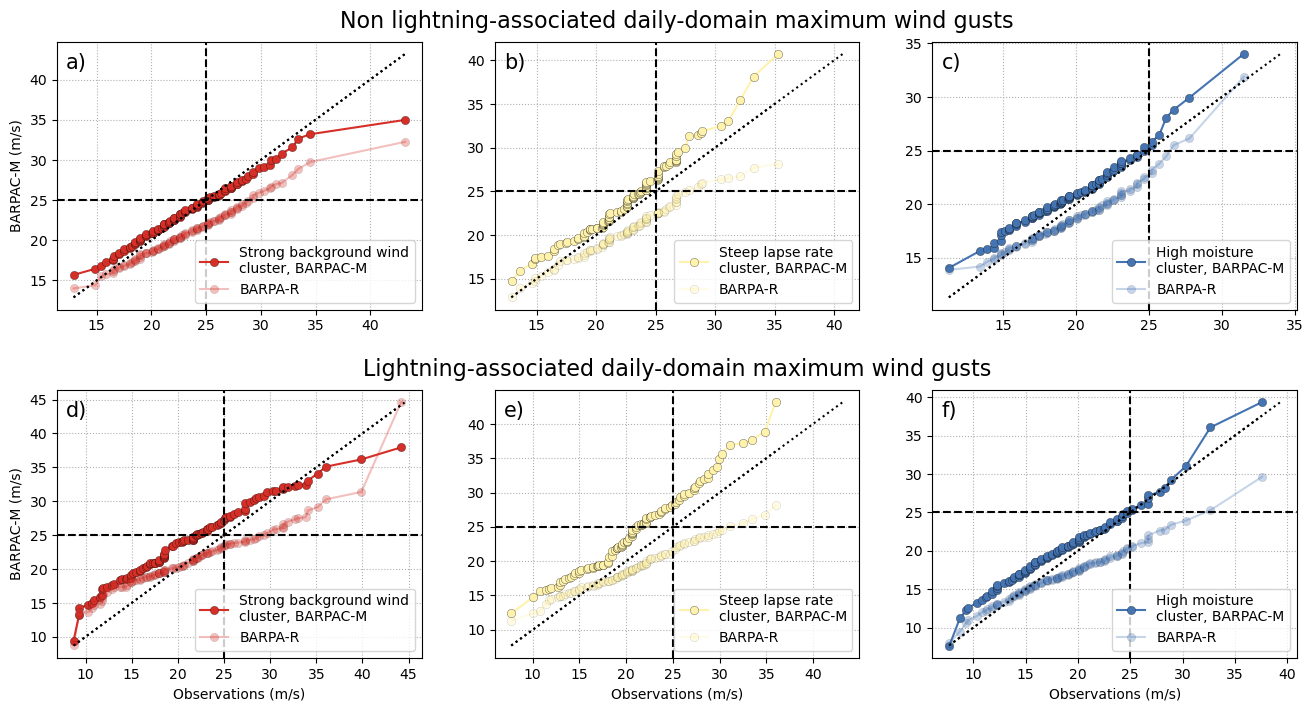

In [15]:
plt.figure(figsize=[16,8])

plt.subplot(2,3,1)
plot_qq(dmax_obs_nonconv.query("cluster_era5==1"),"gust",
        dmax_2p2km_nonconv.query("cluster==1"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="Strong background wind\ncluster, BARPAC-M")
plot_qq(dmax_obs_nonconv.query("cluster_era5==1"),"gust",
        dmax_12km_nonconv.query("cluster==1"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="BARPA-R",alpha=0.3)
plt.ylabel("BARPAC-M (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"a)",transform=plt.gca().transAxes,size=15)

plt.subplot(2,3,2)
plot_qq(dmax_obs_nonconv.query("cluster_era5==2"),"gust",
        dmax_2p2km_nonconv.query("cluster==2"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.46),label="Steep lapse rate\ncluster, BARPAC-M")

plot_qq(dmax_obs_nonconv.query("cluster_era5==2"),"gust",
        dmax_12km_nonconv.query("cluster==2"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.46),label="BARPA-R",alpha=0.3)
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.title("Non lightning-associated daily-domain maximum wind gusts",pad=10,size=16)
plt.text(0.025,0.90,"b)",transform=plt.gca().transAxes,size=15)

plt.subplot(2,3,3)
plot_qq(dmax_obs_nonconv.query("cluster_era5==0"),"gust",
        dmax_2p2km_nonconv.query("cluster==0"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="High moisture\ncluster, BARPAC-M")
plot_qq(dmax_obs_nonconv.query("cluster_era5==0"),"gust",
        dmax_12km_nonconv.query("cluster==0"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="BARPA-R",alpha=0.3)
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"c)",transform=plt.gca().transAxes,size=15)

plt.subplot(2,3,4)
plot_qq(dmax_obs_conv.query("cluster_era5==1"),"gust",
        dmax_2p2km_conv.query("cluster==1"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="Strong background wind\ncluster, BARPAC-M")
plot_qq(dmax_obs_conv.query("cluster_era5==1"),"gust",
        dmax_12km_conv.query("cluster==1"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.1),label="BARPA-R",alpha=0.3)
plt.xlabel("Observations (m/s)")
plt.ylabel("BARPAC-M (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"d)",transform=plt.gca().transAxes,size=15)

plt.subplot(2,3,5)
plot_qq(dmax_obs_conv.query("cluster_era5==2"),"gust",
        dmax_2p2km_conv.query("cluster==2"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.46),label="Steep lapse rate\ncluster, BARPAC-M")
plot_qq(dmax_obs_conv.query("cluster_era5==2"),"gust",
        dmax_12km_conv.query("cluster==2"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.46),label="BARPA-R",alpha=0.3)
plt.xlabel("Observations (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.title("Lightning-associated daily-domain maximum wind gusts",pad=10,size=16)
plt.text(0.025,0.90,"e)",transform=plt.gca().transAxes,size=15)

plt.subplot(2,3,6)
plot_qq(dmax_obs_conv.query("cluster_era5==0"),"gust",
        dmax_2p2km_conv.query("cluster==0"),"wg10_2p2km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="High moisture\ncluster, BARPAC-M")
plot_qq(dmax_obs_conv.query("cluster_era5==0"),"gust",
        dmax_12km_conv.query("cluster==0"),"wg10_12km_point",
        p=100,color=plt.get_cmap("RdYlBu")(0.9),label="BARPA-R",alpha=0.3)
plt.xlabel("Observations (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")
plt.text(0.025,0.90,"f)",transform=plt.gca().transAxes,size=15)

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_qq.jpeg",dpi=400,bbox_inches="tight")

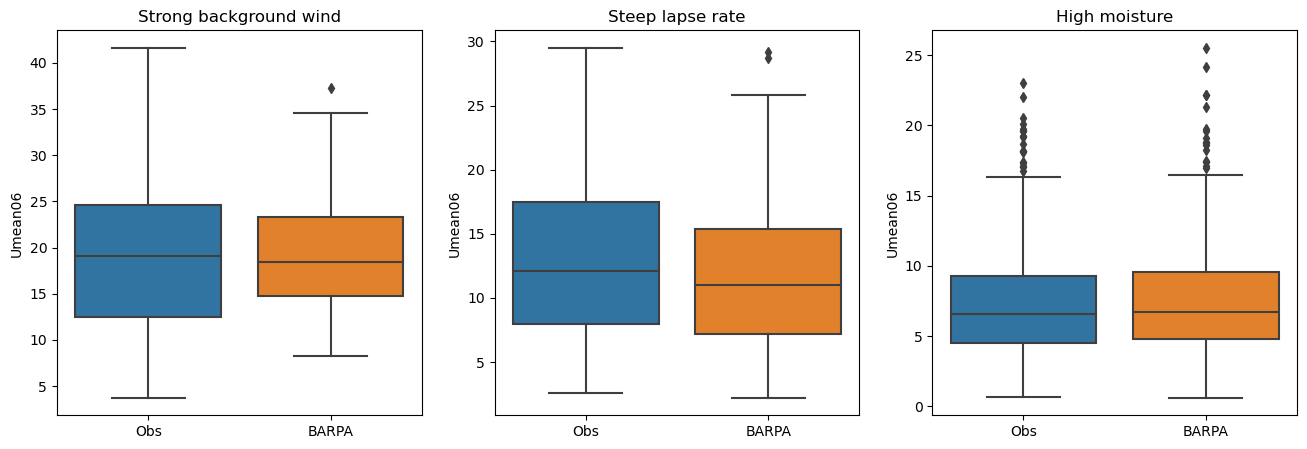

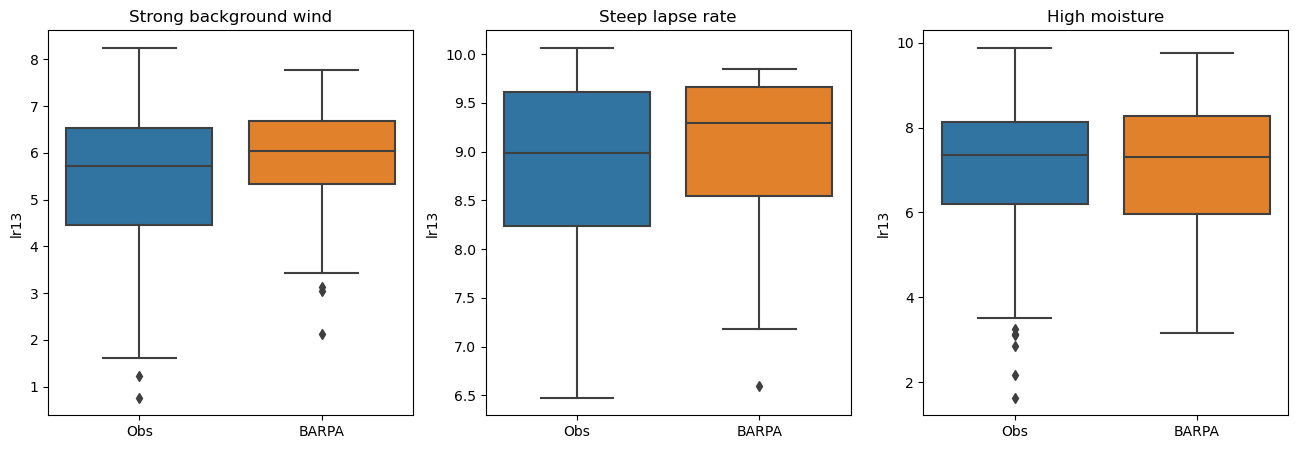

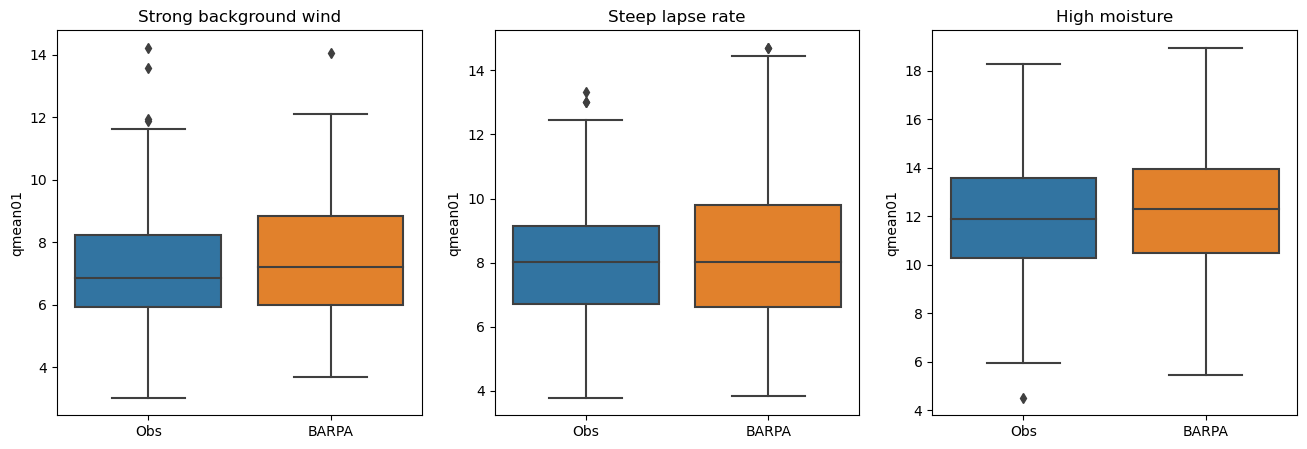

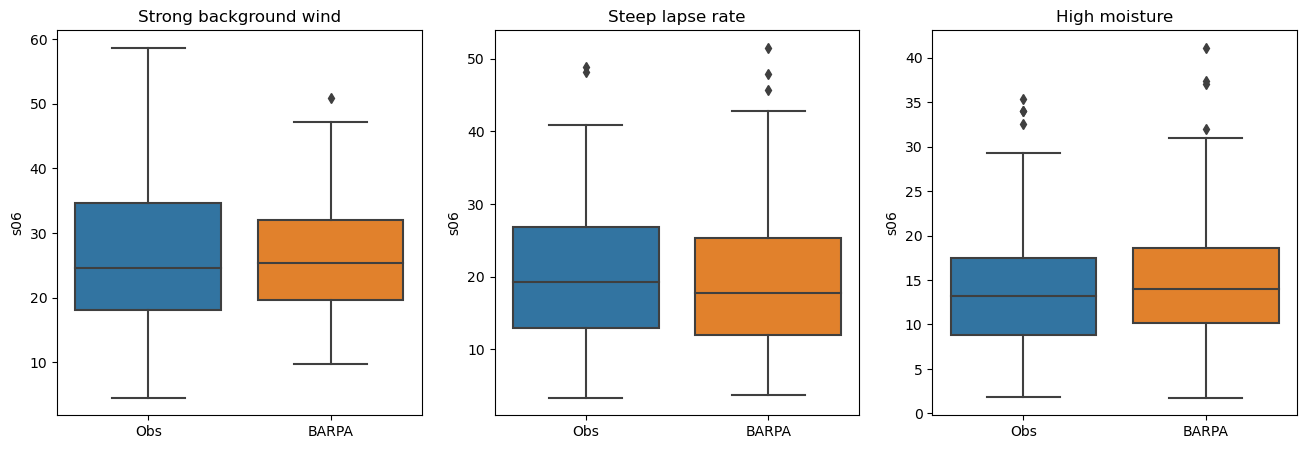

In [16]:
cluster_names = ["Strong background wind","Steep lapse rate","High moisture"]
for v in ["Umean06","lr13","qmean01","s06"]:
    plt.figure(figsize=[16,5])
    cnt=1
    for c in [1,2,0]:
        plt.subplot(1,3,cnt)
        sns.boxplot(data=[dmax_obs_conv[dmax_obs_conv.cluster_era5==c][v+"_era5"],dmax_2p2km_conv[dmax_2p2km_conv.cluster==c][v]])
        plt.xticks([0,1],["Obs","BARPA"])
        plt.title(cluster_names[cnt-1])
        cnt=cnt+1
        plt.ylabel(v)

(1.0, 40000.0)

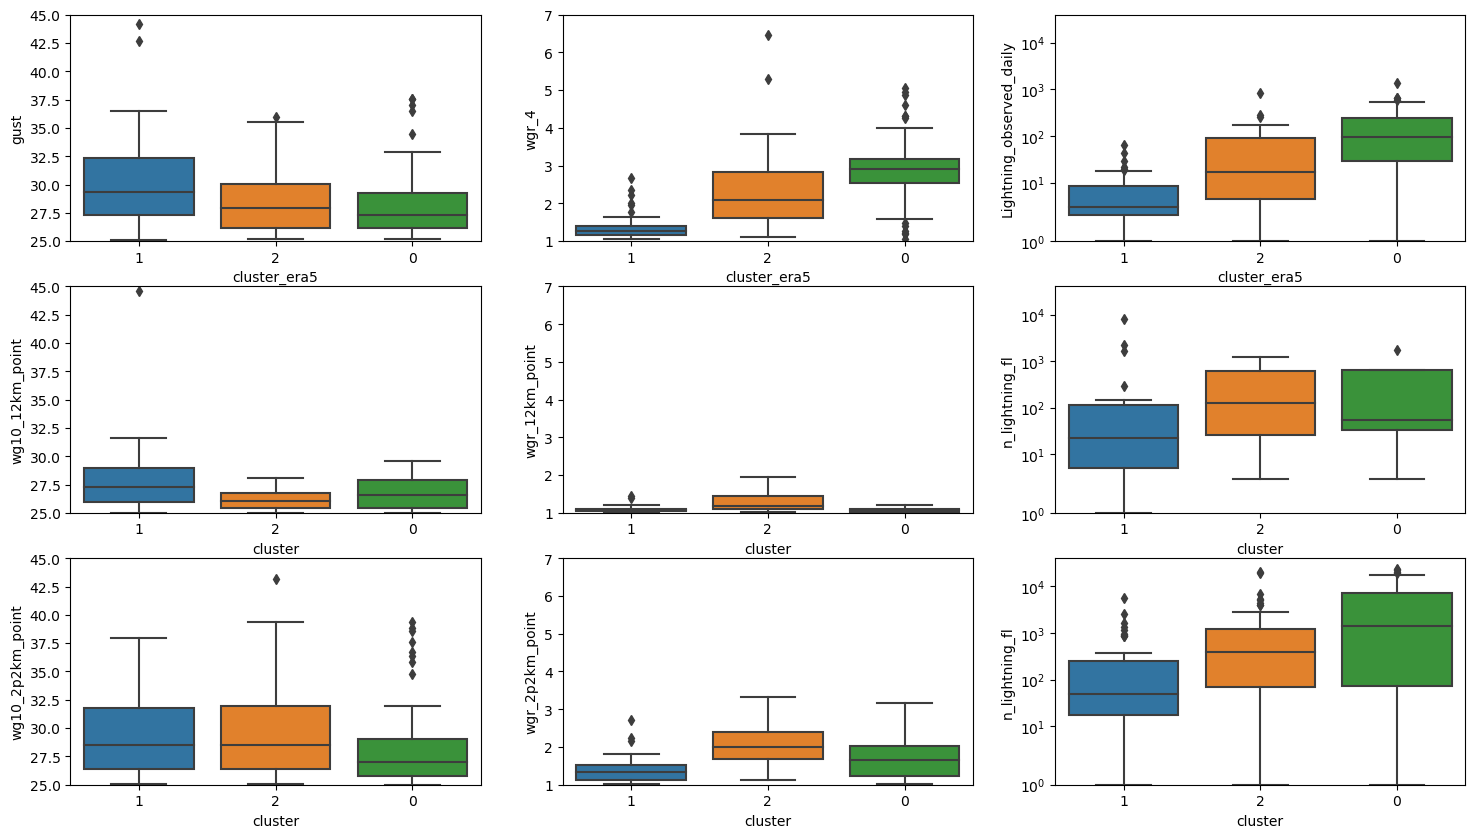

In [17]:
#For severe convective (with lightning) daily-domain maximum gusts (+25 m/s), look at the difference in gust speed, wgr, and lightning between clusters. For each BARPA model, and observations

plt.figure(figsize=[18,10])
plt.subplot(3,3,1); sns.boxplot(data=dmax_obs_conv.query("(Lightning_observed_daily>=1) & (gust>=25)"),x="cluster_era5",y="gust",order=[1,2,0]); plt.ylim([25,45])
plt.subplot(3,3,2); sns.boxplot(data=dmax_obs_conv.query("(Lightning_observed_daily>=1) & (gust>=25)"),x="cluster_era5",y="wgr_4",order=[1,2,0]); plt.ylim([1,7])
plt.subplot(3,3,3); sns.boxplot(data=dmax_obs_conv.query("(Lightning_observed_daily>=1) & (gust>=25)"),x="cluster_era5",y="Lightning_observed_daily",order=[1,2,0]); plt.yscale("symlog"); plt.ylim([1,40000])

plt.subplot(3,3,4); sns.boxplot(data=dmax_12km_conv.query("(n_lightning_fl>=1) & (wg10_12km_point>=25)"),x="cluster",y="wg10_12km_point",order=[1,2,0]); plt.ylim([25,45])
plt.subplot(3,3,5); sns.boxplot(data=dmax_12km_conv.query("(n_lightning_fl>=1) & (wg10_12km_point>=25)"),x="cluster",y="wgr_12km_point",order=[1,2,0]); plt.ylim([1,7])
plt.subplot(3,3,6); sns.boxplot(data=dmax_12km_conv.query("(n_lightning_fl>=1) & (wg10_12km_point>=25)"),x="cluster",y="n_lightning_fl",order=[1,2,0]); plt.yscale("symlog"); plt.ylim([1,40000])

plt.subplot(3,3,7); sns.boxplot(data=dmax_2p2km_conv.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)"),x="cluster",y="wg10_2p2km_point",order=[1,2,0]); plt.ylim([25,45])
plt.subplot(3,3,8); sns.boxplot(data=dmax_2p2km_conv.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)"),x="cluster",y="wgr_2p2km_point",order=[1,2,0]); plt.ylim([1,7])
plt.subplot(3,3,9); sns.boxplot(data=dmax_2p2km_conv.query("(n_lightning_fl>=1) & (wg10_2p2km_point>=25)"),x="cluster",y="n_lightning_fl",order=[1,2,0]); plt.yscale("symlog"); plt.ylim([1,40000])

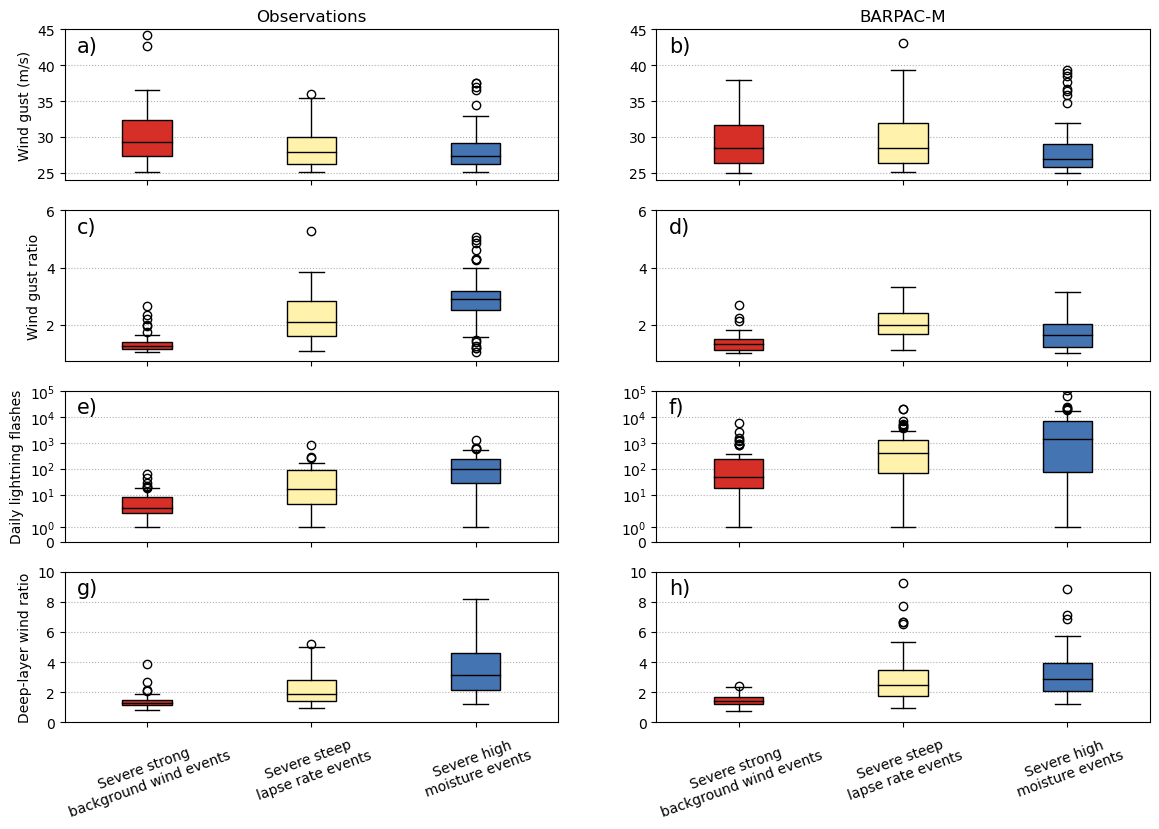

In [63]:
#Same as the above plot, but also considering non-severe domain-daily max gusts as a separate box

def plot_box(df_conv,v,gust_col,letter,xticks=False):
    rgb = [[0.8,0.8,0.8]]
    #p=rgb + [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]    
    p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]    
    
    try:
        b = plt.gca().boxplot([#df_conv[df_conv[gust_col]<25][v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster_era5==1)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster_era5==2)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster_era5==0)")[v]],patch_artist=True);
    except:    
        b = plt.gca().boxplot([#df_conv[df_conv[gust_col]<25][v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster==1)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster==2)")[v],
                      df_conv[df_conv[gust_col]>=25].query("(cluster==0)")[v]],patch_artist=True);        

    for patch, color in zip(b["boxes"], p):
        patch.set(facecolor=color)
    [patch.set(color="k") for patch in b["medians"]]
    
    plt.gca().grid(axis="y",ls=":")
    plt.text(0.025,0.85,letter,transform=plt.gca().transAxes,size=15)
    
    if xticks:
        #plt.xticks([1,2,3,4],["Non-severe convective events","Severe strong background wind events","Severe steep lapse rate events","Severe high moisture events"])
        plt.xticks([1,2,3],["Severe strong\nbackground wind events","Severe steep\nlapse rate events","Severe high\nmoisture events"])
        plt.gca().tick_params("x",rotation=20)
    else:
        #plt.xticks([1,2,3,4],["","","",""])
        plt.xticks([1,2,3],["","",""])


plt.figure(figsize=[14,9])
plt.subplot(4,2,1); plot_box(dmax_obs_conv,"gust","gust","a)");plt.ylim([24,45]); plt.ylabel("Wind gust (m/s)"); plt.title("Observations")
plt.subplot(4,2,3); plot_box(dmax_obs_conv,"wgr_4","gust","c)");plt.ylim([0.75,6]); plt.ylabel("Wind gust ratio")
plt.subplot(4,2,5); plot_box(dmax_obs_conv,"Lightning_observed_daily","gust","e)"); plt.yscale("symlog"); plt.ylim([0,1e5]); plt.ylabel("Daily lightning flashes")
plt.subplot(4,2,7); plot_box(dmax_obs_conv,"dlm_ratio","gust","g)",xticks=True); plt.ylim([0,10]); plt.ylabel("Deep-layer wind ratio")

# plt.subplot(3,3,4); plot_box(dmax_12km_conv,"wg10_12km_point","wg10_12km_point");plt.ylim([5,45])
# plt.subplot(3,3,5); plot_box(dmax_12km_conv,"wgr_12km_point","wg10_12km_point");plt.ylim([1,6])
# plt.subplot(3,3,6); plot_box(dmax_12km_conv,"n_lightning_fl","wg10_12km_point"); plt.yscale("symlog"); plt.ylim([0,1e5])

plt.subplot(4,2,2); plot_box(dmax_2p2km_conv,"wg10_2p2km_point","wg10_2p2km_point","b)");plt.ylim([24,45]); plt.title("BARPAC-M")
plt.subplot(4,2,4); plot_box(dmax_2p2km_conv,"wgr_2p2km_point","wg10_2p2km_point","d)");plt.ylim([0.75,6])
plt.subplot(4,2,6); plot_box(dmax_2p2km_conv,"n_lightning_fl","wg10_2p2km_point","f)"); plt.yscale("symlog"); plt.ylim([0,1e5])
plt.subplot(4,2,8); plot_box(dmax_2p2km_conv,"dlm_ratio","wg10_2p2km_point","h)",xticks=True); plt.ylim([0,10])


plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_stats.jpeg",dpi=400,bbox_inches="tight")

Text(0, 0.5, 'Gust speed (m/s)')

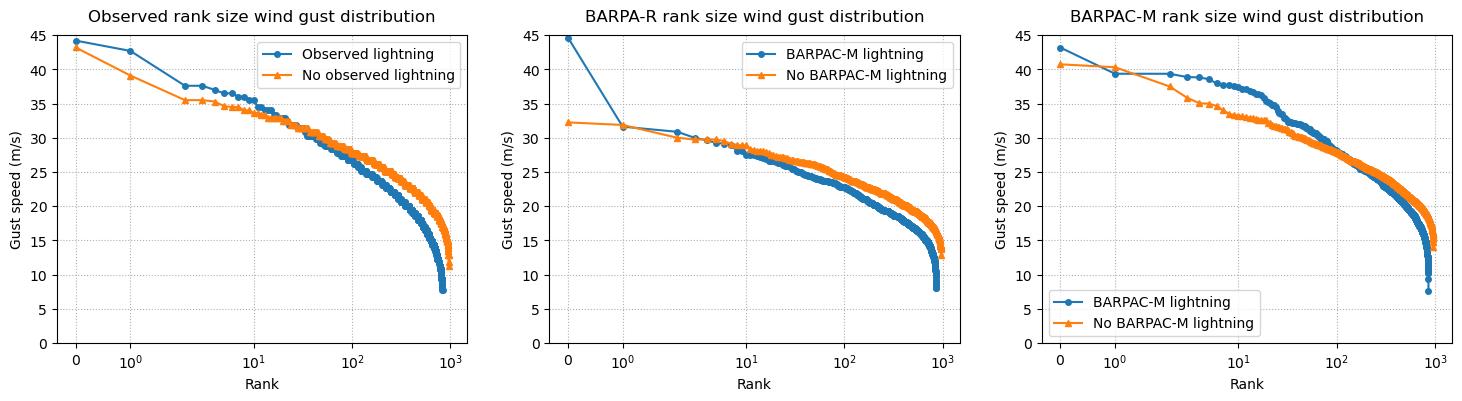

In [19]:
plt.figure(figsize=[18,4])
plt.subplot(1,3,1)

plt.plot(np.flip(np.sort(dmax_obs_conv.gust)),
                 label="Observed lightning",color="tab:blue",marker="o",ms=4)
plt.plot(np.flip(np.sort(dmax_obs_nonconv.gust)),
                 label="No observed lightning",color="tab:orange",marker="^",ms=4)
plt.xscale("symlog")
plt.ylim([0,45])
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("Rank")
plt.title("Observed rank size wind gust distribution",pad=10)
plt.ylabel("Gust speed (m/s)")



plt.subplot(1,3,2)

plt.plot(np.flip(np.sort(dmax_12km_conv.wg10_12km_point)),
                 label="BARPAC-M lightning",color="tab:blue",marker="o",ms=4)
plt.plot(np.flip(np.sort(dmax_12km_nonconv.wg10_12km_point)),
                 label="No BARPAC-M lightning",color="tab:orange",marker="^",ms=4)
plt.xscale("symlog")
plt.ylim([0,45])
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("Rank")
plt.title("BARPA-R rank size wind gust distribution",pad=10)
plt.ylabel("Gust speed (m/s)")



plt.subplot(1,3,3)

plt.plot(np.flip(np.sort(dmax_2p2km_conv.wg10_2p2km_point)),
                 label="BARPAC-M lightning",color="tab:blue",marker="o",ms=4)
plt.plot(np.flip(np.sort(dmax_2p2km_nonconv.wg10_2p2km_point)),
                 label="No BARPAC-M lightning",color="tab:orange",marker="^",ms=4)
plt.xscale("symlog")
plt.ylim([0,45])
plt.gca().grid(ls=":")
plt.legend()
plt.xlabel("Rank")
plt.title("BARPAC-M rank size wind gust distribution",pad=10)
plt.ylabel("Gust speed (m/s)")



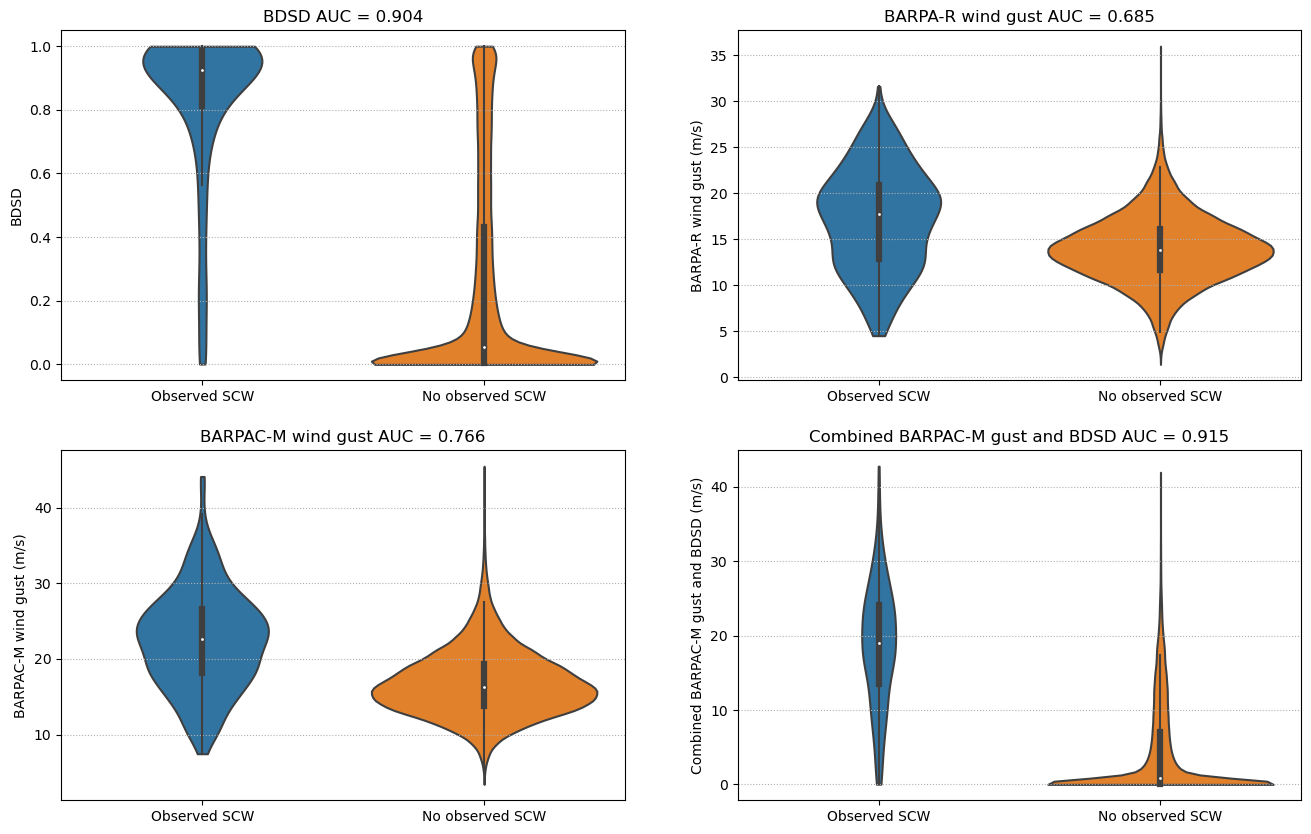

In [20]:
plt.figure(figsize=[16,10])
plt.subplot(2,2,1)
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").bdsd_era5,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").bdsd_era5],cut=0)
plt.title("BDSD AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["bdsd_era5"]),3)))
plt.ylabel("BDSD")
plt.xticks([0,1],["Observed SCW","No observed SCW"])
plt.gca().grid(axis="y",ls=":")

plt.subplot(2,2,2)
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").wg10_12km_rad,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").wg10_12km_rad],cut=0)
plt.title("BARPA-R wind gust AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["wg10_12km_rad"]),3)))
plt.ylabel("BARPA-R wind gust (m/s)")
plt.xticks([0,1],["Observed SCW","No observed SCW"])
plt.gca().grid(axis="y",ls=":")

plt.subplot(2,2,3)
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").wg10_2p2km_rad,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").wg10_2p2km_rad],cut=0)
plt.title("BARPAC-M wind gust AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["wg10_2p2km_rad"]),3)))
plt.ylabel("BARPAC-M wind gust (m/s)")
plt.xticks([0,1],["Observed SCW","No observed SCW"])
plt.gca().grid(axis="y",ls=":")

plt.subplot(2,2,4)
dmax_obs["combo"] = dmax_obs["bdsd_era5"] * dmax_obs["wg10_2p2km_rad"]
sns.violinplot(
    [dmax_obs.query("(Lightning_observed_daily>=1) & (gust>=25)").combo,
    dmax_obs.query("(gust<25) | ((Lightning_observed_daily==0) & (gust>=25))").combo],cut=0)
plt.title("Combined BARPAC-M gust and BDSD AUC = "+str(np.round(roc_auc_score(((dmax_obs["gust"] < 100) & (dmax_obs["Lightning_observed_daily"]>=1) & (dmax_obs["gust"] >= 25)).values * 1,
              dmax_obs["combo"]),3)))
plt.ylabel("Combined BARPAC-M gust and BDSD (m/s)")
plt.xticks([0,1],["Observed SCW","No observed SCW"]);
plt.gca().grid(axis="y",ls=":");

In [55]:
def get_local_hour(events):
    vic = load_stn_info("vic")
    nsw = load_stn_info("nsw")
    sa = load_stn_info("sa")
    tas = load_stn_info("tas")
    stn_info = pd.concat([vic,nsw,sa,tas],axis=0)

    lons = [stn_info[stn_info["stn_no"]==s][["lon"]].values[0,0] for s in events.stn_id]
    lats = [stn_info[stn_info["stn_no"]==s][["lat"]].values[0,0] for s in events.stn_id]
    tzs = [tf.timezone_at_land(lng=lon, lat=lat) for lon,lat in zip(lons,lats)]

    hour = [pd.to_datetime(t,utc=True).tz_convert(tz).hour for t,tz in zip(events.time.values,tzs)]
    
    return hour

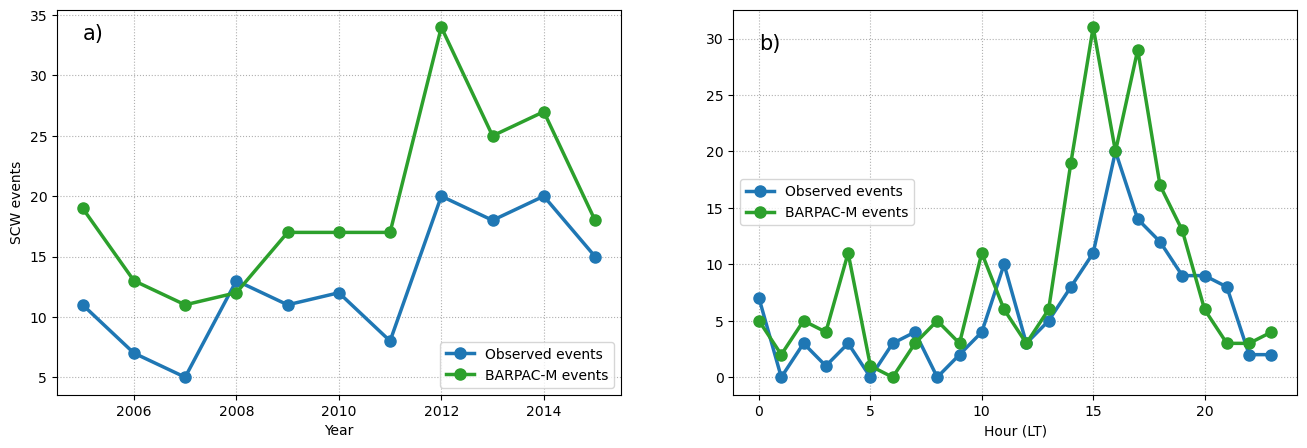

In [59]:
plt.figure(figsize=[16,5])

plt.subplot(1,2,1)

plt.plot(np.arange(2005,2016),
         [(pd.to_datetime(dmax_obs_conv.query("(gust>=25)").time).dt.year == y).sum() for y in np.arange(2005,2016)],
         marker="o",label="Observed events",color="tab:blue",lw=2.5,ms=8)
plt.plot(np.arange(2005,2016),
         [(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").time).dt.year == h).sum() for h in np.arange(2005,2016)],
         marker="o",label="BARPAC-M events",color="tab:green",lw=2.5,ms=8)
plt.gca().grid(ls=":")
plt.ylabel("SCW events")
plt.xlabel("Year")
plt.text(2005,33,"a)",size=15)
plt.legend(loc=4)

plt.subplot(1,2,2)



# plt.plot(np.arange(0,24),
#          [(pd.to_datetime(dmax_obs_conv.query("(gust>=25)").time).dt.hour == h).sum() for h in np.arange(0,24)],
#          marker="o",label="Observed events",color="tab:blue",lw=2.5,ms=8)
# plt.plot(np.arange(0,24),
#          [(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)").time).dt.hour == h).sum() for h in np.arange(0,24)],
#          marker="o",label="BARPAC-M events",color="tab:green",lw=2.5,ms=8)
plt.plot(np.arange(0,24),
         [(get_local_hour(dmax_obs_conv.query("(gust>=25)")) == h).sum() for h in np.arange(0,24)],
         marker="o",label="Observed events",color="tab:blue",lw=2.5,ms=8)
plt.plot(np.arange(0,24),
         [(get_local_hour(dmax_2p2km_conv.query("(wg10_2p2km_point>=25)")) == h).sum() for h in np.arange(0,24)],
         marker="o",label="BARPAC-M events",color="tab:green",lw=2.5,ms=8)

plt.gca().grid(ls=":")
plt.xlabel("Hour (LT)")
plt.text(0,29,"b)",size=15)
plt.legend(loc=6)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/temporal_variability.jpeg",dpi=400,bbox_inches="tight")

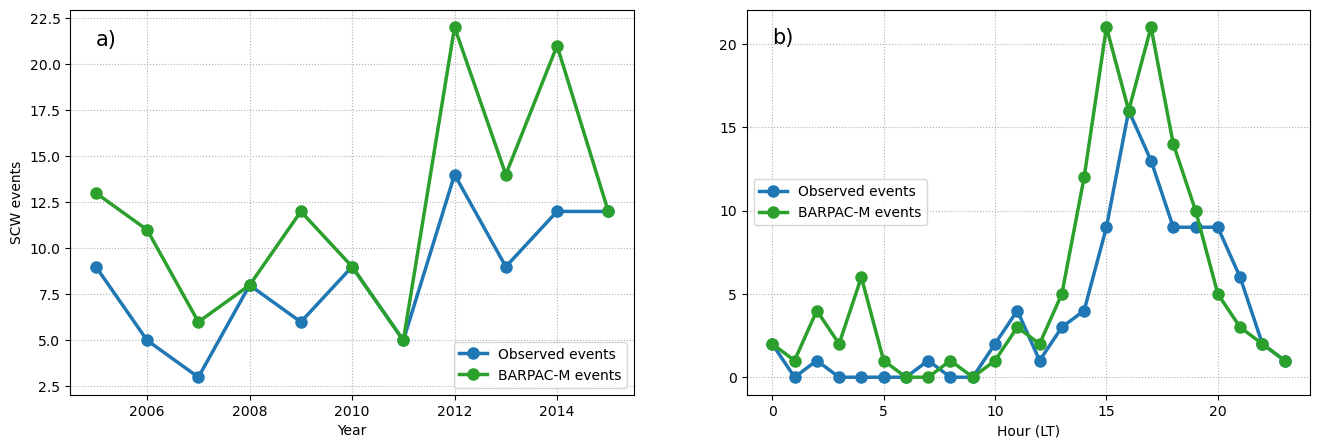

In [61]:
plt.figure(figsize=[16,5])

plt.subplot(1,2,1)

plt.plot(np.arange(2005,2016),
         [(pd.to_datetime(dmax_obs_conv.query("(gust>=25) & (wgr_4>=1.5)").time).dt.year == y).sum() for y in np.arange(2005,2016)],
         marker="o",label="Observed events",color="tab:blue",lw=2.5,ms=8)
plt.plot(np.arange(2005,2016),
         [(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25) & (wgr_2p2km_point>=1.5)").time).dt.year == h).sum() for h in np.arange(2005,2016)],
         marker="o",label="BARPAC-M events",color="tab:green",lw=2.5,ms=8)
plt.gca().grid(ls=":")
plt.ylabel("SCW events")
plt.xlabel("Year")
plt.text(2005,21,"a)",size=15)
plt.legend(loc=4)

plt.subplot(1,2,2)

# plt.plot(np.arange(0,24),
#          [(pd.to_datetime(dmax_obs_conv.query("(gust>=25) & (wgr_4>=1.5)").time).dt.hour == h).sum() for h in np.arange(0,24)],
#          marker="o",label="Observed events",color="tab:blue",lw=2.5,ms=8)
# plt.plot(np.arange(0,24),
#          [(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25) & (wgr_2p2km_point>=1.5)").time).dt.hour == h).sum() for h in np.arange(0,24)],
#          marker="o",label="BARPAC-M events",color="tab:green",lw=2.5,ms=8)
plt.plot(np.arange(0,24),
         [(get_local_hour(dmax_obs_conv.query("(gust>=25) & (wgr_4>=1.5)")) == h).sum() for h in np.arange(0,24)],
         marker="o",label="Observed events",color="tab:blue",lw=2.5,ms=8)
plt.plot(np.arange(0,24),
         [(get_local_hour(dmax_2p2km_conv.query("(wg10_2p2km_point>=25) & (wgr_2p2km_point>=1.5)")) == h).sum() for h in np.arange(0,24)],
         marker="o",label="BARPAC-M events",color="tab:green",lw=2.5,ms=8)
plt.gca().grid(ls=":")
plt.xlabel("Hour (LT)")
plt.legend(loc=6)
plt.text(0,20,"b)",size=15)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/temporal_variability_with_wgr_thresh.jpeg",dpi=400,bbox_inches="tight")

In [18]:
spearmanr(
    [(pd.to_datetime(dmax_obs_conv.query("(gust>=25)").time).dt.year == h).sum() for h in np.arange(2005,2016)],
    [(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25) ").time).dt.year == h).sum() for h in np.arange(2005,2016)])

SignificanceResult(statistic=0.7926351445067078, pvalue=0.0036185978004378994)

In [22]:
spearmanr(
    [(pd.to_datetime(dmax_obs_conv.query("(gust>=25) & (wgr_4>=1.5)").time).dt.year == h).sum() for h in np.arange(2005,2016)],
    [(pd.to_datetime(dmax_2p2km_conv.query("(wg10_2p2km_point>=25) & (wgr_2p2km_point>=1.5)").time).dt.year == h).sum() for h in np.arange(2005,2016)])

SignificanceResult(statistic=0.801439115483673, pvalue=0.003017678900873629)

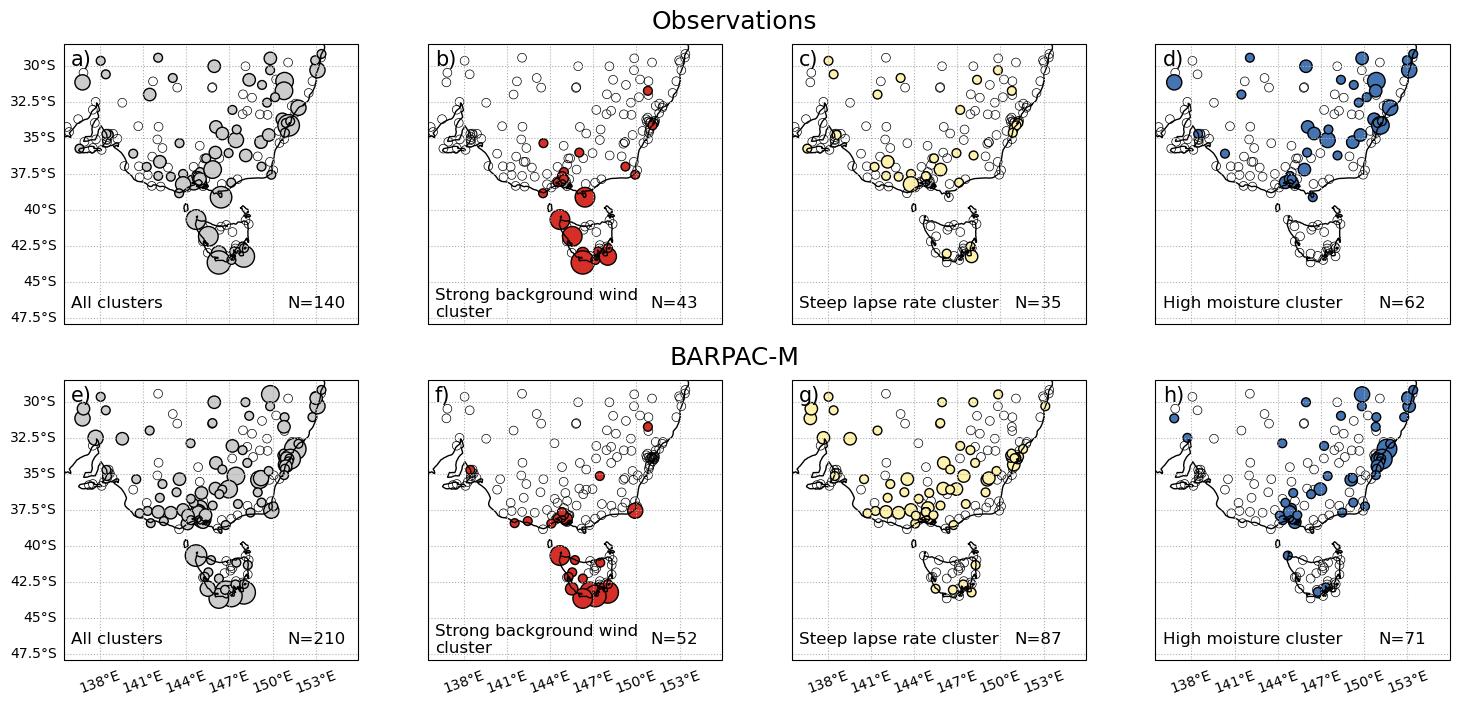

In [68]:
def plot_event_map(ax,cluster,df,data,stn_info,letter,ytick=False,xtick=False):
    rgb=[[0.8,0.8,0.8]]
    p=rgb + [plt.get_cmap("RdYlBu")(i) for i in [0.9,0.1,0.46]]    

    stn_events = []
    lons = []
    lats = []    
    if cluster >= 0:
        if data=="obs":
            for stn in df.stn_id.unique():
                stn_events.append(df[df.stn_id==stn].query("(gust>=25) & (cluster_era5=="+str(cluster)+")").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])                           
        elif data=="model":
            for stn in df.stn_id.unique():
                stn_events.append(df[df.stn_id==stn].query("(wg10_2p2km_point>=25) & (cluster=="+str(cluster)+")").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])                
    else:
        if data=="obs":
            for stn in df.stn_id.unique():
                stn_events.append(df[df.stn_id==stn].query("(gust>=25)").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])            
        elif data=="model":
            for stn in df.stn_id.unique():
                stn_events.append(df[df.stn_id==stn].query("(wg10_2p2km_point>=25)").shape[0])
                lons.append(stn_info[stn_info.stn_no==stn]["lon"])
                lats.append(stn_info[stn_info.stn_no==stn]["lat"])       

    stn_events=np.array(stn_events)
    lons=np.array(lons)    
    lats=np.array(lats)    
    ax.scatter(lons[stn_events==0],lats[stn_events==0],marker="o",color="none",s=40,edgecolor="k",linewidths=0.5)
    ax.scatter(lons[stn_events>0],lats[stn_events>0],marker="o",color=p[cluster+1],s=stn_events[stn_events>0]*40,edgecolor="k")
                            
    ax.text(151,-46.5,"N="+str(stn_events.sum()),fontdict={"size":12,"va":"center"})
    cluster_names = ["All clusters","High moisture cluster","Strong background wind\ncluster","Steep lapse rate cluster"]
    ax.text(136,-46.5,cluster_names[cluster+1],fontdict={"size":12,"va":"center"})
    
    ax.coastlines()
    ax.set_ylim(lat_lims)
    ax.set_xlim(lon_lims)
    ax.text(0.025,0.925,letter,transform=ax.transAxes,size=15)
    
    g=ax.gridlines(draw_labels=True,ylabel_style={"size":10},xlabel_style={"size":10,"rotation":20},ls=":");
    g.top_labels=False; g.right_labels=False
    if not ytick:
        g.left_labels = False
    if not xtick:
        g.bottom_labels = False
    
    
vic = load_stn_info("vic")
nsw = load_stn_info("nsw")
sa = load_stn_info("sa")
tas = load_stn_info("tas")
stn_info = pd.concat([vic,nsw,sa,tas],axis=0)

f=xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/topog-BARPAC-M_km2p2.nc")
lon_lims = [f.longitude.values.min(),f.longitude.values.max()]
lat_lims = [f.latitude.values.min(),f.latitude.values.max()+0.5]    
    
    
fig=plt.figure(figsize=[18,8])

plot_event_map(plt.subplot(2,4,1,projection=ccrs.PlateCarree()), -1, dmax_obs_conv, "obs", stn_info, "a)", ytick=True)
plot_event_map(plt.subplot(2,4,5,projection=ccrs.PlateCarree()), -1, dmax_2p2km_conv, "model", stn_info, "e)", ytick=True, xtick=True)

plot_event_map(plt.subplot(2,4,2,projection=ccrs.PlateCarree()), 1, dmax_obs_conv, "obs", stn_info, "b)")
plot_event_map(plt.subplot(2,4,6,projection=ccrs.PlateCarree()), 1, dmax_2p2km_conv, "model", stn_info, "f)", xtick=True)

plot_event_map(plt.subplot(2,4,3,projection=ccrs.PlateCarree()), 2, dmax_obs_conv, "obs", stn_info, "c)")
plot_event_map(plt.subplot(2,4,7,projection=ccrs.PlateCarree()), 2, dmax_2p2km_conv, "model", stn_info, "g)", xtick=True)

plot_event_map(plt.subplot(2,4,4,projection=ccrs.PlateCarree()), 0, dmax_obs_conv, "obs", stn_info, "d)")
plot_event_map(plt.subplot(2,4,8,projection=ccrs.PlateCarree()), 0, dmax_2p2km_conv, "model", stn_info, "h)", xtick=True)

plt.text(0.5,0.9,"Observations",transform=fig.transFigure,size=18,ha="center")
plt.text(0.5,0.48,"BARPAC-M",transform=fig.transFigure,size=18,ha="center")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_map.jpeg",dpi=400,bbox_inches="tight")

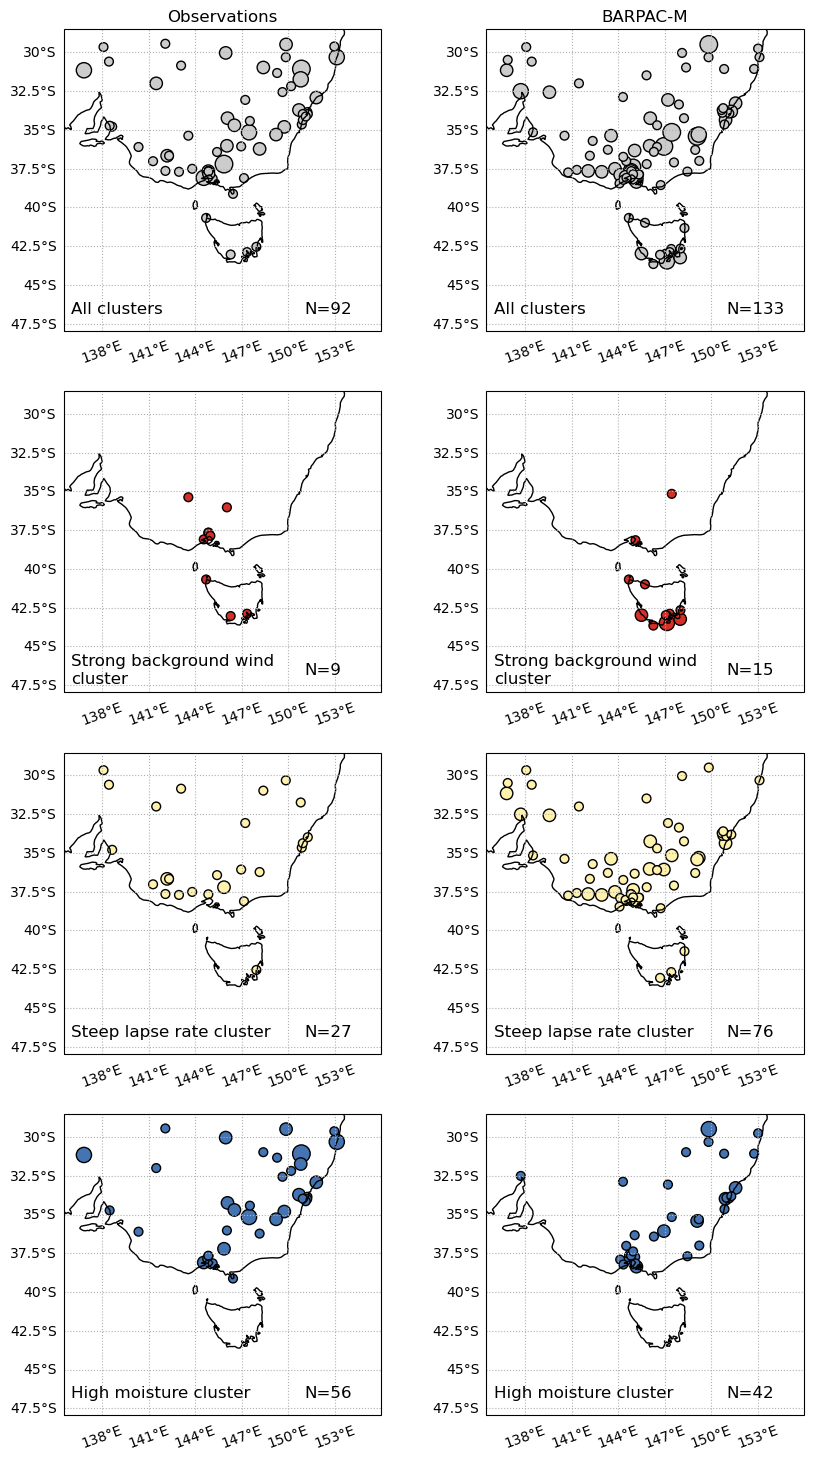

In [23]:
def plot_event_map(ax,cluster,df,data,stn_info):
    rgb=[[0.8,0.8,0.8]]
    p=rgb + [plt.get_cmap("RdYlBu")(i) for i in [0.9,0.1,0.46]]    

    if cluster >= 0:
        if data=="obs":
            stn_events = df.query("(gust>=25) & (cluster_era5=="+str(cluster)+") & (wgr_4>=1.5)").stn_id.value_counts()
        elif data=="model":
            stn_events = df.query("(wg10_2p2km_point>=25) & (cluster=="+str(cluster)+") & (wgr_2p2km_point>=1.5)").stn_id.value_counts()
    else:
        if data=="obs":
            stn_events = df.query("(gust>=25) & (wgr_4>=1.5)").stn_id.value_counts()
        elif data=="model":
            stn_events = df.query("(wg10_2p2km_point>=25) & (wgr_2p2km_point>=1.5)").stn_id.value_counts()      

    lons = [stn_info[stn_info.stn_no==ind]["lon"] for ind,val in stn_events.items()]
    lats = [stn_info[stn_info.stn_no==ind]["lat"] for ind,val in stn_events.items()]

    ax.scatter(lons,lats,marker="o",color=p[cluster+1],s=stn_events.values*40,edgecolor="k")
    ax.text(151,-46.5,"N="+str(stn_events.sum()),fontdict={"size":12,"va":"center"})
    cluster_names = ["All clusters","High moisture cluster","Strong background wind\ncluster","Steep lapse rate cluster"]
    ax.text(136,-46.5,cluster_names[cluster+1],fontdict={"size":12,"va":"center"})
    
    ax.coastlines()
    ax.set_ylim(lat_lims)
    ax.set_xlim(lon_lims)
    g=ax.gridlines(draw_labels=True,ylabel_style={"size":10},xlabel_style={"size":10,"rotation":20},ls=":"); g.top_labels=False; g.right_labels=False
    
    
vic = load_stn_info("vic")
nsw = load_stn_info("nsw")
sa = load_stn_info("sa")
tas = load_stn_info("tas")
stn_info = pd.concat([vic,nsw,sa,tas],axis=0)

f=xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/topog-BARPAC-M_km2p2.nc")
lon_lims = [f.longitude.values.min(),f.longitude.values.max()]
lat_lims = [f.latitude.values.min(),f.latitude.values.max()+0.5]    
    
    
plt.figure(figsize=[10,18])

plot_event_map(plt.subplot(4,2,1,projection=ccrs.PlateCarree()), -1, dmax_obs_conv, "obs", stn_info); plt.title("Observations")
plot_event_map(plt.subplot(4,2,2,projection=ccrs.PlateCarree()), -1, dmax_2p2km_conv, "model", stn_info); plt.title("BARPAC-M")

plot_event_map(plt.subplot(4,2,3,projection=ccrs.PlateCarree()), 1, dmax_obs_conv, "obs", stn_info)
plot_event_map(plt.subplot(4,2,4,projection=ccrs.PlateCarree()), 1, dmax_2p2km_conv, "model", stn_info)

plot_event_map(plt.subplot(4,2,5,projection=ccrs.PlateCarree()), 2, dmax_obs_conv, "obs", stn_info)
plot_event_map(plt.subplot(4,2,6,projection=ccrs.PlateCarree()), 2, dmax_2p2km_conv, "model", stn_info)

plot_event_map(plt.subplot(4,2,7,projection=ccrs.PlateCarree()), 0, dmax_obs_conv, "obs", stn_info)
plot_event_map(plt.subplot(4,2,8,projection=ccrs.PlateCarree()), 0, dmax_2p2km_conv, "model", stn_info)

#plt.savefig("/g/data/eg3/ab4502/figs/barpa/cluster_map.jpeg",dpi=400,bbox_inches="tight")